# Audible Data Analysis <a id='top'></a>

#### Data Scraped on 5/10/21

- [Introduction & Requirements](#intro)
- [Data Import](#import)
- [Data Preparation](#data_prep)
- [Library Growth](#library)
- [Time Series Investigation](#time_series)
- [Titles & Subtitles](#titles_sub)
- [Authors & Narrators](#auth_narr)
- [Author as Narrator](#auth_as_narr)
- [Languages](#lang)
- [Length](#length)
- [Price](#price)
- [Price vs Length](#price_length)
- [Bang for your Buck](#bang4buck)
- [Reviews and Ratings](#reviews)
- [Categories](#categories)
- [Translation as Service](#translation)
- [Audible Category Analysis](#cats)
- [Category EDA](#cat_eda)
- [Category Networks](#network)


### Introduction & Requirements <a id='intro'></a>
This notebook documents the data analysis of the title and category information scraped from Audible.com and Amazon.com. Generally we will focus on book length, price, ratings, and number of listens. 

Please run the web scraping programs below before analsis. Static images will be included in the presentation accompanying this notebook. **Confirm requirements.txt is met**:
- books_scrapy_audible -> category_spider
- books_scrapy_audible -> titles_spider

Running these programs should result in the following csv files
- books_scrapy_audible -> category_hierarchy_n_urls.csv
- books_scrapy_audible -> title_information.csv

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
from statistics import mode
import networkx as nx
import matplotlib.pyplot as plt
import missingno

### Data Import <a id='import'></a>
Due to the nature of the scraping program, which you can read about in the README.md, most titles have been scraped multiple times. Luckily all urls lead to the same product and are unique so they can help us easily filter for unique titles, and categories can be condensed into a list which will act like a list of tags. 

In [205]:
cat_data   = pd.read_csv("books_scrapy_audible/category_hierarchy_n_urls.csv")
title_data = pd.read_csv("books_scrapy_audible/title_information.csv")

In [3]:
title_data.head()

,author,count_rating,language,length,narrator,pod_flag,price,release_date,star_rating,subtitle,title,title_category,title_url
0,Yuval Noah Harari,43059.0,English,917,Derek Perkins,False,34.22,08-15-17,4.5,A Brief History of Humankind,Sapiens,Biological Sciences,https://www.audible.com/pd/Sapiens-Audiobook/B...
1,Walter Isaacson,1622.0,English,964,"Kathe Mazur,Walter Isaacson",False,28.34,03-09-21,4.5,"Jennifer Doudna, Gene Editing, and the Future ...",The Code Breaker,Biological Sciences,https://www.audible.com/pd/The-Code-Breaker-Au...
2,James Nestor,4300.0,English,438,James Nestor,False,24.50,05-26-20,5.0,The New Science of a Lost Art,Breath,Biological Sciences,https://www.audible.com/pd/Breath-Audiobook/05...
3,Robin Wall Kimmerer,4346.0,English,1004,Robin Wall Kimmerer,False,34.99,12-27-15,5.0,"Indigenous Wisdom, Scientific Knowledge and th...",Braiding Sweetgrass,Biological Sciences,https://www.audible.com/pd/Braiding-Sweetgrass...
4,Suzanne Simard,5.0,English,733,Suzanne Simard,False,31.50,05-04-21,5.0,Discovering the Wisdom of the Forest,Finding the Mother Tree,Biological Sciences,https://www.audible.com/pd/Finding-the-Mother-...


In [3]:
cat_data.head()

,category_name,category_numb_title,leaf_flag,parent_category,parent_url,self_url,title_list_url
0,Travel & Tourism,8631,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Travel-Tourism-Aud...,https://www.audible.com/search?node=1858109501...
1,Teen,18661,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Teen-Audiobooks/18...,https://www.audible.com/search?node=1858071501...
2,Sports & Outdoors,22415,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Sports-Outdoors-Au...,https://www.audible.com/search?node=1858064801...
3,Science Fiction & Fantasy,61202,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Science-Fiction-Fa...,https://www.audible.com/search?node=1858060601...
4,Science & Engineering,17495,False,Audible,https://www.audible.com/categories,https://www.audible.com/cat/Science-Engineerin...,https://www.audible.com/search?node=1858054001...


# Data Preparation <a id='data_prep'></a>
[Back to top](#top)

#### Cleaning Duplicates and Filtering Podcasts
Since Audible treats categories more like tags, most titles belonging to multiple, there is a significant number of duplicated titles and information. 


Podcasts are also present in our data. Generally podcasts are listed under a seperate URL however, it seems some are cross-listed with audiobook categories. Since they are not the focus of the scraping, these ~7000 podcasts they are discarded from our dataset but offer an alternative path with a rewritten scraper. 

Number of titles scraped:  622065
Number of unique titles (books+pods):  286200
Unique Podcasts:  6959
Unique Books:  279241


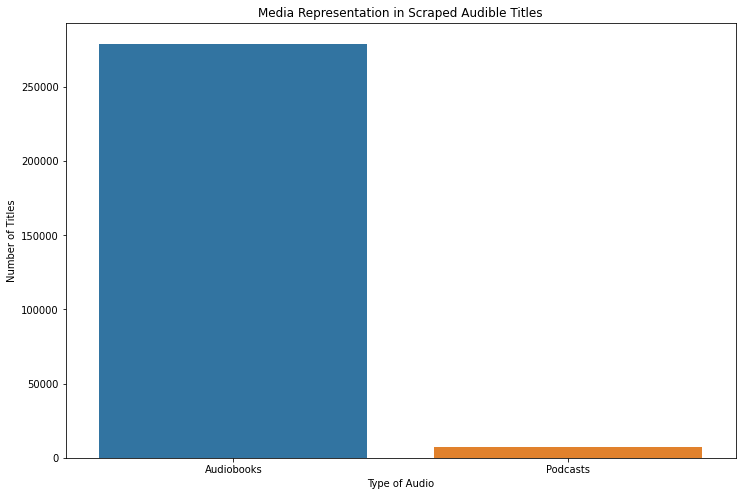

In [206]:
print("Number of titles scraped: ", len(title_data.title_url) )
print("Number of unique titles (books+pods): ", len(np.unique(title_data.title_url)))
print("Unique Podcasts: ",len(np.unique(title_data.title_url[title_data.pod_flag == True])))
print("Unique Books: ",len(np.unique(title_data.title_url[title_data.pod_flag == False])))

data = np.where(title_data.drop_duplicates(subset = ['title_url'])['pod_flag'] == True, "Podcasts", "Audiobooks" )
sns.countplot(x=data).set(xlabel="Type of Audio", ylabel = "Number of Titles")

plt.title("Media Representation in Scraped Audible Titles")

plt.savefig("./graphics/media_types.png", bbox_inches = 'tight')

In [208]:
# Remove podcasts from dataframe
title_data = title_data.loc[title_data.pod_flag == False]
# Dropping a mis-formated podcast
title_data = title_data.loc[title_data.title != 'Wälder News']

Due to titles appearing in multiple categories, other fields were effected which were cleaned in the following manner.
- **title_category**: collapsed into a list.
- **count_rating**: max value retained.  
- **star_rating**: max value retained.
- **release_date**: max value retained. I believe this is due to reuploading into a new category.
- **length**: max value retained. I believe this is due to reuploading into a new category.
- **category_number**: New Column, number of categories a title was scraped in.
- **Other Columns**: Most common value taken.

In [209]:
titles = title_data.groupby('title_url', dropna = False).agg({
                                              'author'        :mode,
                                              'language'      :mode,
                                              'narrator'      :mode,
                                              'pod_flag'      :mode,
                                              'price'         :mode,
                                              'subtitle'      :mode,
                                              'title'         :mode,
                                              'release_date'  :'max',
                                              'length'        :'max',
                                              'star_rating'   :'max', 
                                              'count_rating'  :'max',
                                              'title_category': lambda x: list(x)}
                                            ).reset_index()




"This leaves {} books remaining, compared to the +200,000 reported publically by Audible".format(len(np.unique(titles.title_url)))

'This leaves 279240 books remaining, compared to the +200,000 reported publically by Audible'

Overall, we have recovered 279240 audiobooks which is in line with Audibles reported numbers.

#### Filling missing values and adding new columns for later use.
Most code chunks will also derive the column in case chunks are run out of order. 

In [210]:
titles.drop('pod_flag', axis =1)

titles['subtitle']      = titles['subtitle'].replace(np.nan, "")
titles['count_rating']  = titles['count_rating'].fillna(0)

titles['category_number'] = titles['title_category'].str.len()

titles['author']        = [x.split(',') for x in titles.author.replace(np.nan,"")]
titles['narrator']      = [x.split(',') for x in titles.narrator.replace(np.nan,"")]

titles['pub_datetime']  = pd.to_datetime(titles.release_date, format='%m-%d-%y')
titles['cumm_lang_pub'] = titles.sort_values('pub_datetime', ascending = True).groupby('language',dropna=True).cumcount()

titles['language']      = titles['language'].str.replace("_"," ").str.title()

titles['star_rating']   = titles['star_rating'].astype('string').replace(np.nan,"")

# 54 books had prices missing, droping to make life easier.
titles = titles[titles.price.notnull()]

# Library Growth <a id='library'></a>
[Back to top](#top)

The growth of any service is often impacted by outside events the company experiences. Below, I look at the cummulative audiobooks added compared to multiple events in Audible's company history. From the graph below, we can see that most of Audible's library growth has occured in the 12 years since Audible was purchased by Amazon. However, the company was already on a growth trajectory before the acquisition, in 2000 a large number of titles were added and after the iTunes deal the rate of growth appears to increase and hold steady.

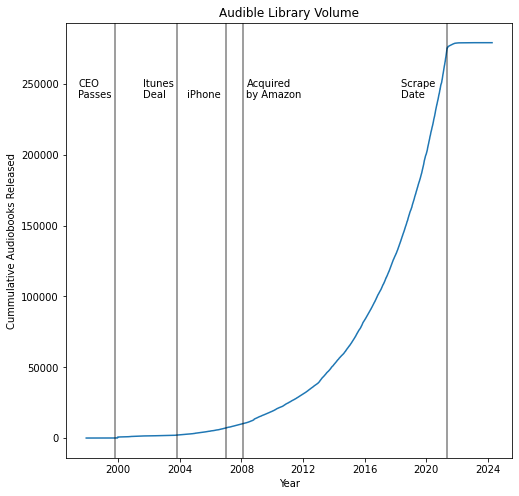

In [8]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
titles['cumm_pub'] = titles.sort_values('pub_datetime', ascending = True).reset_index().index

plt.rcParams['figure.figsize'] = (8,8)

plot = sns.lineplot( 
             x   = titles.pub_datetime.sort_values(), 
             y   = titles.reset_index().index,
             ci  = None)

plt.title("Audible Library Volume")
plot.set_xlabel("Year")
plot.set_ylabel("Cummulative Audiobooks Released")
#plot.set_yscale('log')

# CEO Passed
plot.axvline(x=pd.to_datetime("1999-10-24"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("1997-05-24"),240000, "CEO\nPasses", color ='k')

# Exclsive provider of audiobooks for itunes
plot.axvline(x=pd.to_datetime("2003-10-16"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2001-08-16"),240000, "iTunes\nDeal", color ='k')

# iphone released
plot.axvline(x=pd.to_datetime("2007-01-09"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2004-06-09"),240000, "iPhone", color ='k')

# amazon purchase
plot.axvline(x=pd.to_datetime("2008-01-31"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2008-04-30"),240000, "Acquired\nby Amazon", color ='k')

# Scrape Date 
plot.axvline(x=pd.to_datetime("2021-05-10"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2018-05-10"),240000, "Scrape \nDate", color ='k')

plt.savefig("./graphics/library_timeseries.png", bbox_inches = 'tight')

Below, the number of titles added each year is shown. In the early 2000s there was declining number of releases but after 2003 and 2004 new releases start to increase again, likely due to the cash infusion from the itunes deal.

Another interesting phenomenon is the 2013-2014 releases. In 2014 nearly the same number of books were added as the previous year, which might at first seem to be due to some sort of slowdown or hickup in production. However, a deeper investigation (see next image) release that 2013 is the abnormal year, seeing a 31% increase over the previous year when ~24% is the norm for the leading and trailing years. A possible explanation is the creation of the Audiobook Creation Exchange (ACX) which connects Rights Holders (authors, companies) with voice actors as well as automatically distributing the finished audiobook to Audible, Amazon, and iTunes. Launched in 2011, it [experienced 10x growth in 2012](https://web.archive.org/web/20140106204531/http://www.nextadvisor.com/blog/2013/02/04/audibles-audiobook-creation-exchange-reports-big-growth-in-2012/) which would show itself in an increase in books being published in the following year.

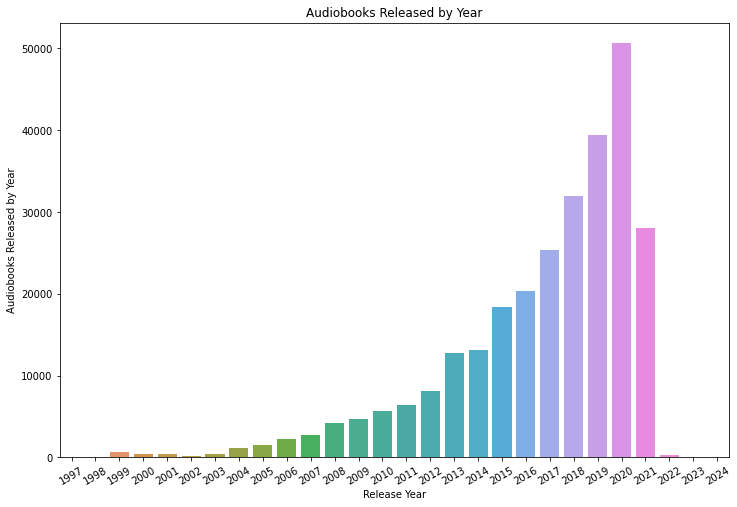

In [124]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
years = pd.DatetimeIndex(titles.pub_datetime).year

plt.rcParams['figure.figsize'] = (12,8)

plot = sns.countplot(x = years)

plot.set_xticklabels(range(1997,2025))

plt.title("Audiobooks Released by Year")
plot.set_xlabel("Release Year")
plt.xticks(rotation =30)
plot.set_ylabel("Audiobooks Released by Year")

plt.savefig("./graphics/lang_timeseries_box.png", bbox_inches = 'tight')

Below, the year-over-year growth rate is shown by year. The graph was trimmed to exclude 1997, 1998, 1999, and 2021+. Future years are trimmed due to incomplete data, the early years of Audible have variable growth rates due to such a low volume of titles (i.e. a 4000% growth rate in 1999).

The below graph tells a story of a company maturing and stabilizing its growth rate at nearly 25% year over year, (2015-2020: 28%, 24.3%, 24.5%, 24.7%, 24.5%, 25.3%), (likely someone's bonus requires hitting that target). 

It is estimated that 500,000 to 1 million books are published year year in the United States. This gives Audible 10 years at the current growth rate before they begin to approach that thresehold. 

<ipython-input-101-40fa18fa4dca>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(yticks)


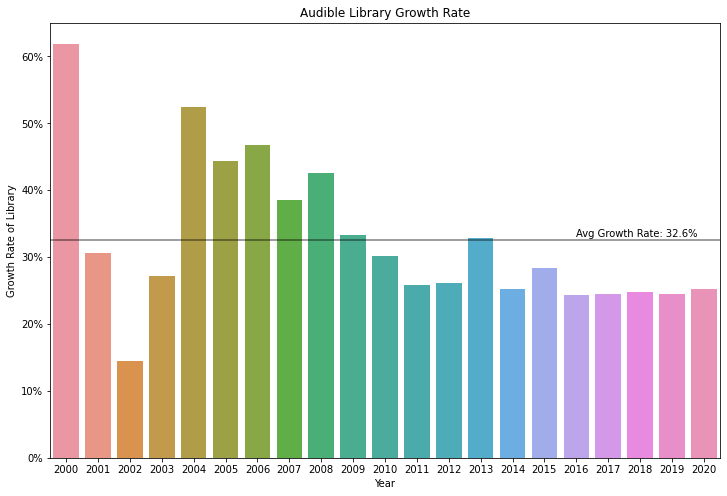

In [101]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
years = pd.DatetimeIndex(titles.pub_datetime).year
years = years.value_counts().sort_index().drop(labels = [2021,2022,2023,2024])
years = np.cumsum(years)

diff_y = years.diff().drop(labels = [1997])
years = years.drop(labels = [2020])

perc_change = pd.Series([(x/y)*100 for x, y in list(zip(diff_y, years))],index = diff_y.index)
perc_change = perc_change.drop(labels = [1998,1999])

plt.rcParams['figure.figsize'] = (12,8)

plot = sns.barplot(x=perc_change.index, y =perc_change)

plot.axhline(y= np.mean(perc_change), xmin=0, xmax=1, color = 'k',alpha = 0.5)
plot.text(16,33, "Avg Growth Rate: {:.1f}%".format(np.mean(perc_change)), color ='k')

yticks = [str(x)+"%" for x in range(0,70,10)]
plot.set_yticklabels(yticks)

plt.title("Audible Library Growth Rate")
plot.set_xlabel("Year")
plot.set_ylabel("Growth Rate of Library")

plt.savefig("./graphics/growth_rate.png", bbox_inches = 'tight')

# Time Series Investigation <a id='time_series'></a>
[Back to top](#top)

Below are several 'quick and dirty' timeseries graphs of several variables against time. Of these, the only two with interesting features are the number of categories a book is listed under, and the star ratings of each titles. 

Category Number:
- I think this is best explained by Audibles categories-as-tags system; Older audiobooks have collected more tags over time, or authors are finding that listing under fewer tags produces better results during discovery.

Star Rating:
- This is likely recency bias, more recent books are more likely to have been listened to by people excited or interested in them. We may be observing time scaling, where older ratings are given less weight compared to more recent ratings (IMDB uses a similar system).

<AxesSubplot:xlabel='pub_datetime', ylabel='category_number'>

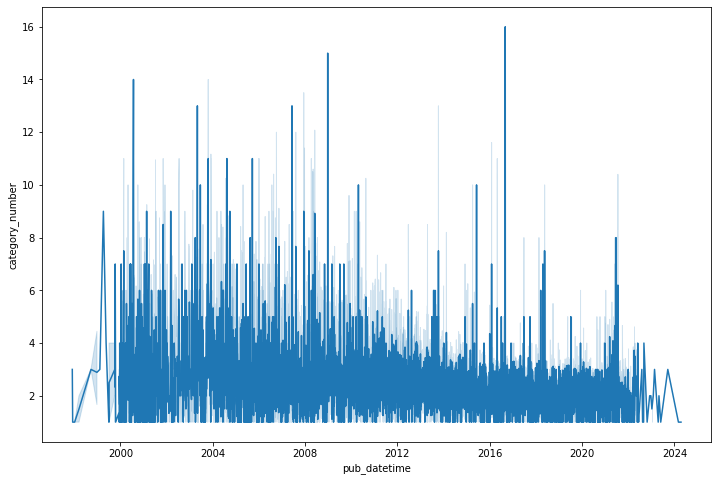

In [13]:
sns.lineplot(x=titles.pub_datetime,
             y=titles.category_number,err_style='band')

<AxesSubplot:xlabel='pub_datetime', ylabel='star_rating'>

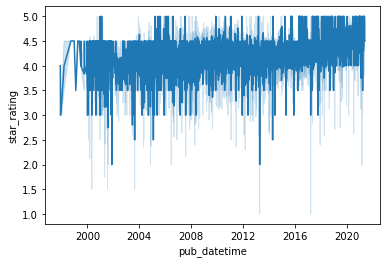

In [153]:
sns.lineplot(x=titles.pub_datetime,
             y=titles.star_rating.replace("",np.nan).astype(float) )

<AxesSubplot:xlabel='pub_datetime', ylabel='star_rating'>

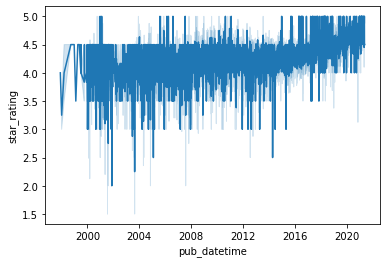

In [159]:
# examining stars again but only titles with more than 4 reviews.
sns.lineplot(x = titles[titles.count_rating>4]['pub_datetime'],
            y = titles[titles.count_rating>4]['star_rating'].astype(float))

<AxesSubplot:xlabel='pub_datetime', ylabel='length'>

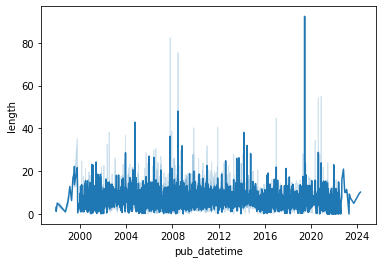

In [136]:
sns.lineplot(x=titles.pub_datetime,
             y=(titles.length/60) )

<AxesSubplot:xlabel='pub_datetime', ylabel='price'>

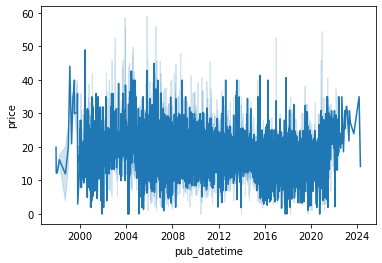

In [149]:
sns.lineplot(x=titles.pub_datetime,
             y=titles.price )

<AxesSubplot:xlabel='pub_datetime', ylabel='count_rating'>

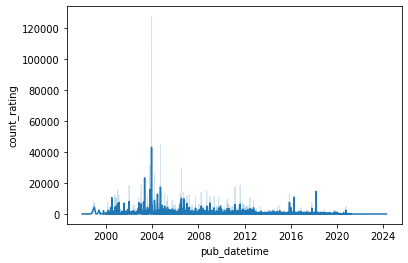

In [150]:
sns.lineplot(x=titles.pub_datetime,
             y=titles.count_rating )

# Titles and Subtitles <a id='titles_sub'></a>
[Back to top](#top)

It appears that including a subtitle is more popular than excluding one and when a subtitle is included they are on average longer than the average titles. The most common subtitle length (besides 0) is 5 words, while the most common title length is only 3 words. Like much of the scaped Audible data, the distribution is extremely skewed. With some titles reaching 50 words and some subtitles nearly reaching 70. 

These long titles appear to be a side effect of two phenomena: guides, which tend to have longer (sub)titles explaining their use, and non-english language, which prompts authors to add an english translation to their (sub)title.

Subtitle       168614
No Subtitle    110687
Name: subtitle, dtype: int64
279301


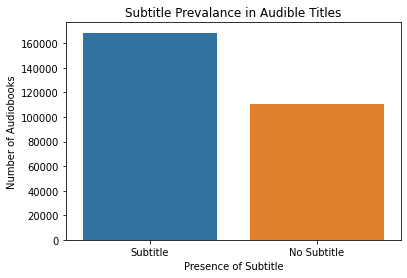

In [109]:
data = (titles['subtitle'] != "").replace({True:"Subtitle",False:"No Subtitle"})
plot = sns.countplot(x=data)

plot.set_xlabel("Presence of Subtitle") 
plot.set_ylabel("Number of Audiobooks")

plt.title("Subtitle Prevalance in Audible Titles")

plt.savefig("./graphics/sub-title_count.png", bbox_inches = 'tight')
print(data.value_counts())
print(len(data))

Percent with Subtitles: 60.4%
Median title length: 4.0
Mode title length: 0    3
dtype: int64
Median subtitle length: 4.0
Mode subtitle length: 0    0
dtype: int64
Median subtitle length (non-zero): 6.0
Mode subtitle length (non-zero): 0    5
dtype: int64


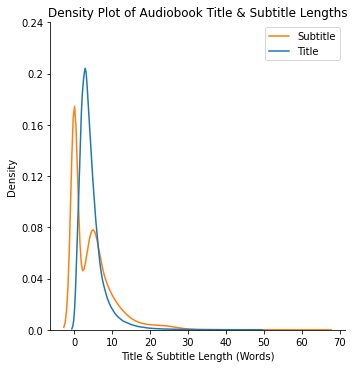

In [112]:
sub_data_word = titles.subtitle.str.split().str.len()
title_data_word = titles.title.str.split().str.len()

data = pd.concat([title_data_word,sub_data_word], axis=1).stack().reset_index()
data.columns = ['Index','Feature','Length']
data['Feature'] = data['Feature'].str.title()

plot = sns.displot(data = data, x = 'Length',kind = 'kde', legend= False, hue = 'Feature',bw_adjust = 2)

plt.legend(["Subtitle","Title"])
plot.set_axis_labels("Title & Subtitle Length (Words)")
plt.title("Density Plot of Audiobook Title & Subtitle Lengths")


yticks = [x/200 for x in range(0,25,4)]
ylabels = [x*2 for x in yticks]
plt.yticks(yticks, ylabels)

plt.savefig("./graphics/title_subtitle_word_hist.png", bbox_inches = 'tight')

print("Percent with Subtitles: {:.1f}%".format(np.mean(sub_data_word != 0)*100))
print("Median title length: {}".format(title_data_word.median()))
print("Mode title length: {}".format(title_data_word.mode()))
print("Median subtitle length: {}".format(sub_data_word.median()))
print("Mode subtitle length: {}".format(sub_data_word.mode()))
print("Median subtitle length (non-zero): {}".format(sub_data_word[sub_data_word !=0].median()))
print("Mode subtitle length (non-zero): {}".format(sub_data_word[sub_data_word !=0].mode()))

#### Longest Titles

In [145]:
#pd.set_option('display.max_colwidth', None)
titles['title_length'] = titles.title.str.split().str.len() 
titles.sort_values('title_length', ascending = False).head(3)[['author','narrator','language','title','subtitle','price','star_rating','count_rating','release_date']]

# weirdly the counts are the same?
# similar release date

,author,narrator,language,title,subtitle,price,star_rating,count_rating,release_date
92732,[Giselle Johnson],[Keymer Roa],Spanish,Guía de Viaje económica de Tailandia: Tips ese...,,6.95,5.0,200.0,01-17-20
92733,[Giselle Johnson],[Keymer Roa],Spanish,Guía de Viaje económica de Tailandia: Tips ese...,,6.95,5.0,200.0,01-14-20
92724,[Giselle Johnson],[Keymer Roa],Spanish,Guía de Viaje económica de Alemania: Tips esen...,,6.95,5.0,200.0,01-14-20


#### Longest Subtitles

In [263]:
#pd.set_option('display.max_colwidth', None)

titles['subtitle_length'] = titles.subtitle.str.split().str.len() 
titles.sort_values('subtitle_length', ascending = False).head(3)[['author','narrator','language','title','subtitle','price','star_rating','count_rating']]


,author,narrator,language,title,subtitle,price,star_rating,count_rating
112042,[Dr. Stanley Leary],[Gonzalo Abad Cortes],Spanish,Inteligencia Emotional (Emotional Intelligence),"La Guia Definitiva Para La Felicidad, Aumentar...",19.95,5.0,3.0
199800,"[The Cosmovisioners, Carlos Augusto Miguel Gue...",[Dinorah Pena-Duran],Spanish,Tarot Para Principiantes [Tarot for Beginners],Guía simple e intuitiva para aprender la lectu...,14.95,5.0,25.0
221877,"[John Wesley Hardin, Frank Triplett, Charles A...",[Museum Audiobooks cast],English,The Gunmen of the American Wild West Collection,"The Life of John Wesley Hardin, Jesse James: T...",41.99,,0.0


EDA regarding the length of titles and subtitles against the other variables of interest. No interesting relationship found.

<AxesSubplot:xlabel='title_data_word', ylabel='star_rating'>

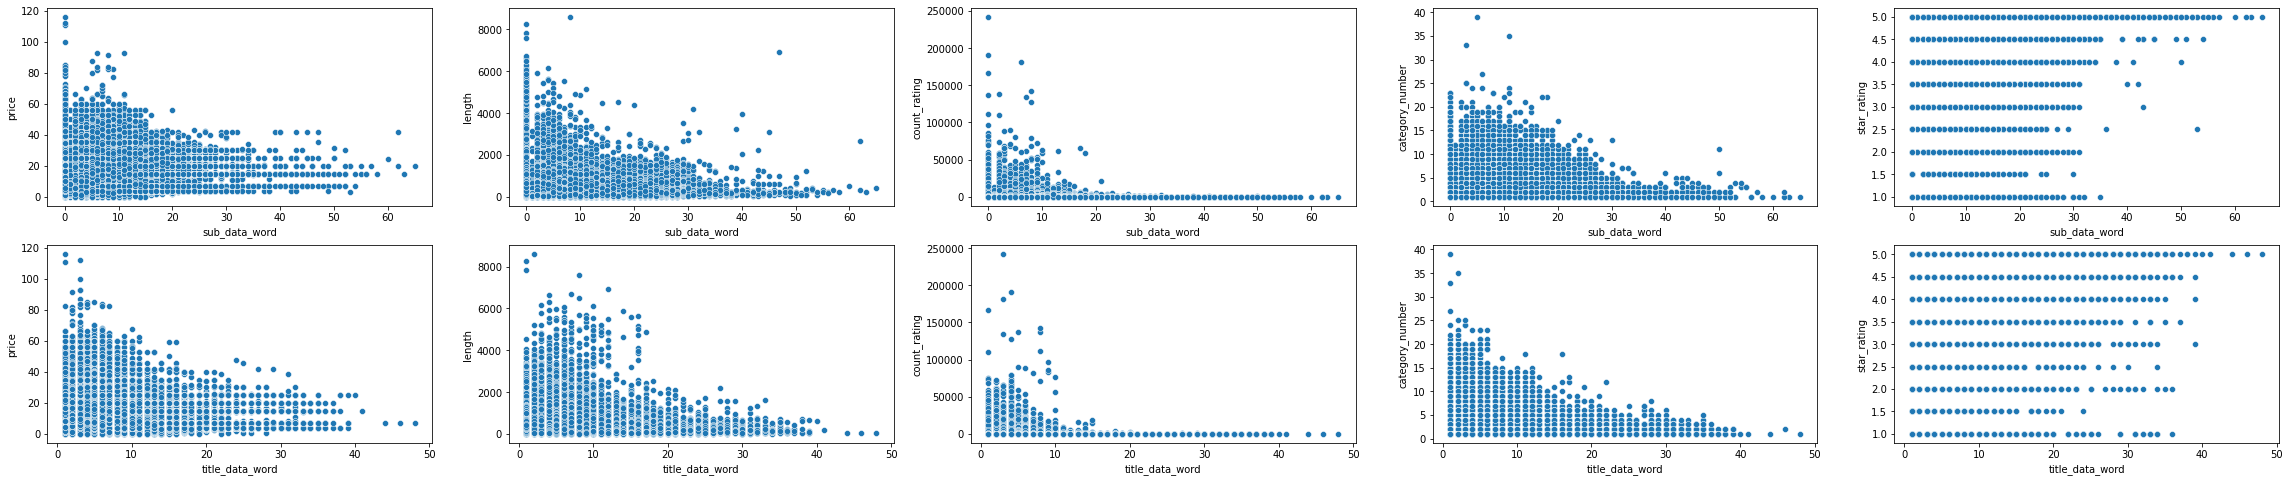

In [133]:
titles['sub_data_word'] = titles.subtitle.str.split().str.len()
titles['title_data_word'] = titles.title.str.split().str.len()

fig, axs = plt.subplots(ncols=5, nrows=2)
fig.set_figwidth(40)
sns.scatterplot(x='sub_data_word',
                y='price',
               data = titles,
                ax= axs[0,0])
sns.scatterplot(x='sub_data_word',
                y='length',
               data = titles,
                ax= axs[0,1],
              )
sns.scatterplot(x='sub_data_word',
                y='count_rating',
               data = titles,
                ax= axs[0,2])
sns.scatterplot(x='sub_data_word',
                y='category_number',
               data = titles,
                ax= axs[0,3])
sns.scatterplot(x=titles['sub_data_word'],
                y=titles.star_rating.replace("",np.nan).astype(float),
                ax= axs[0,4])
sns.scatterplot(x='title_data_word',
                y='price',
               data = titles,
                ax= axs[1,0])
sns.scatterplot(x='title_data_word',
                y='length',
               data = titles,
                ax= axs[1,1])
sns.scatterplot(x='title_data_word',
                y='count_rating',
               data = titles,
                ax= axs[1,2])
sns.scatterplot(x='title_data_word',
                y='category_number',
               data = titles,
                ax= axs[1,3])
sns.scatterplot(x=titles['title_data_word'],
                y=titles.star_rating.replace("",np.nan).astype(float),
                ax= axs[1,4])


# Authors and Narrators <a id='auth_narr'></a>
[Back to top](#top)

Again, the data scraped from Audible is heavily skewed, a vast majority of Authors and Narrators produce 1 or 2 audiobooks, while a select few produce thousdands.

Some of the top Authors are organizations which produces specific content such as J.M. Gardner who produces a variety of translation books ("1000 essential words in \_\_\_"). Due to the popularity and lack of copywright, many versions of Shakespear have been created. Lastly, we have incredibly productive authors such as James Patterson who has authors over 300 audiobooks.

Narrators seem to have more individuals breaking into the top 10, 4 of the 10 are single narrators. Scott Brick has narrated over 500 books from Dune and IRobot to Jack Reacher. 

In [137]:
titles_authors = titles.explode('author')
titles_narrators = titles.explode('narrator')


0    1
dtype: int64
1.0
2.515967601285264


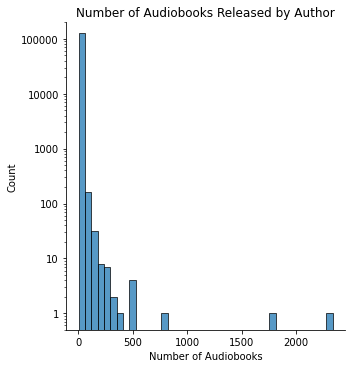

In [43]:
data = titles_authors.author.value_counts(ascending=False)

plot = sns.displot(x=data, kind = 'hist', bins = 40)

plt.xlabel("Number of Audiobooks")
plt.title("Number of Audiobooks Released by Author")
plt.yscale('log')

yticks = [0.01, 0.1,1,10,100,1000,10000,100000,1000000,10000000]
plot.set_yticklabels(yticks)
plt.ylim(0.5,200000)


plt.savefig("./graphics/prolific_authors_dist.png", bbox_inches = 'tight')
print(data.mode())
print(data.median())
print(data.mean())

J. M. Gardner                   2338
Charles River Editors           1755
Innovative Language Learning     812
Pimsleur                         521
div.                             501
William Shakespeare              500
The Great Courses                499
Captivating History              366
Greater Than a Tourist           351
James Patterson                  305
Name: author, dtype: int64


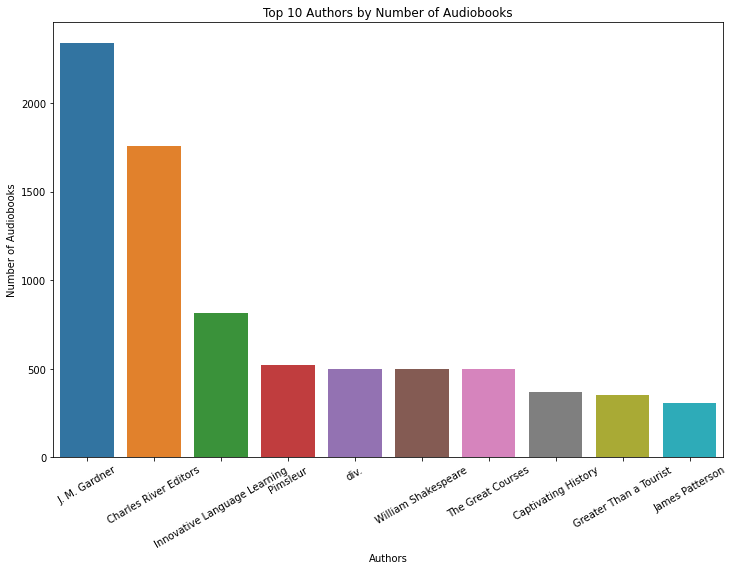

In [53]:
data = titles_authors.author.value_counts(ascending=False)[0:10]
print(data)
plot = sns.barplot(x=data.index, y = data.values)

plt.xticks(rotation = 30)
plt.xlabel("Authors")
plt.ylabel("Number of Audiobooks")
plt.title("Top 10 Authors by Number of Audiobooks")

plt.savefig("./graphics/prolific_authors.png", bbox_inches = 'tight')

0    1
dtype: int64
1.0
4.829688213796254


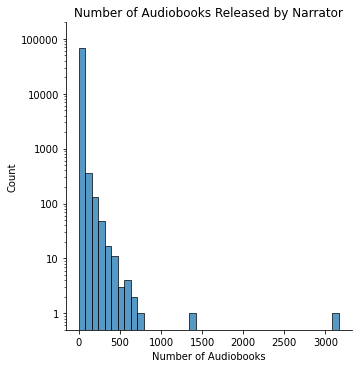

In [55]:
data = titles_narrators.narrator.value_counts(ascending=False)

plot = sns.displot(x=data, kind = 'hist',bins=40)

plt.xlabel("Number of Audiobooks")
plt.title("Number of Audiobooks Released by Narrator")
plt.yscale('log')

yticks = [0.01, 0.1,1,10,100,1000,10000,100000,1000000,10000000]
plot.set_yticklabels(yticks)
plt.ylim(0.5,200000)

print(data.mode())
print(data.median())
print(data.mean())

plt.savefig("./graphics/prolific_narrators_dist.png", bbox_inches = 'tight')

                      3164
full cast             1356
uncredited             717
Scott Brick            670
Al Kessel              636
Cassandra Campbell     617
Simon Vance            586
Intuitive              567
div.                   566
Pimsleur               521
Name: narrator, dtype: int64


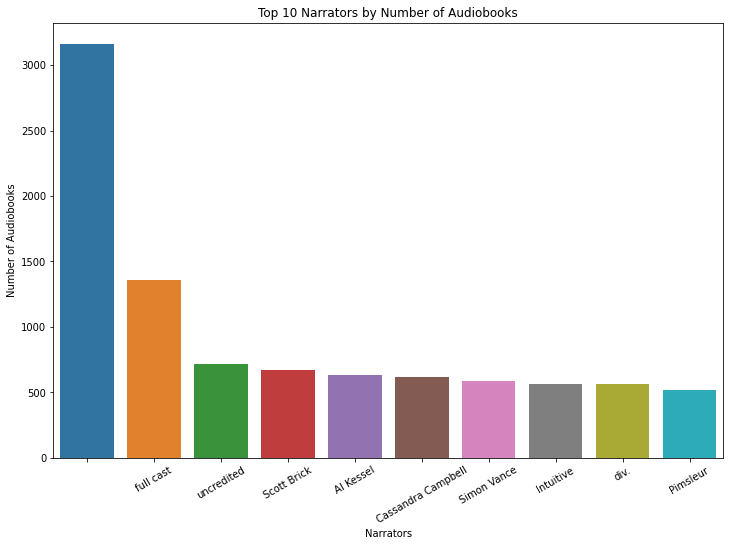

In [56]:
data = titles_narrators.narrator.value_counts(ascending=False)[0:10]
print(data)
plot = sns.barplot(x=data.index, y = data.values)

plt.xticks(rotation = 30)
plt.xlabel("Narrators")
plt.ylabel("Number of Audiobooks")
plt.title("Top 10 Narrators by Number of Audiobooks")

plt.savefig("./graphics/prolific_narrators.png", bbox_inches = 'tight')

Below we pivot the by-author and by-narrator dataframes to capture summary stats about each specific author and narrator. Along with the number of authors and narrators attached to each book the summary statistics are shown compared to the number of authors or each author specifically, unfortunetly nothing stood out for further investigation.

In [248]:
titles_authors['star_rating'] = titles_authors.star_rating.replace("",np.nan).astype(float)
titles_narrators['star_rating'] = titles_narrators.star_rating.replace("",np.nan).astype(float)

new_columns = {'star_rating':'mean',
               'count_rating':['mean','sum'],
               "category_number":'mean',
               'length':['mean','sum'], 
               'title':'count',
               'price':'mean',
               'language':'nunique'}

auth_stats = titles_authors.groupby('author').agg(new_columns)
narr_stats = titles_narrators.groupby('narrator').agg(new_columns)

In [250]:
auth_stats.head()

star_rating count_rating       category_number  \
                                mean         mean   sum            mean   
author                                                                    
"Sharkey" Ward                  5.00          1.0   1.0             3.0   
"Triathlon Taren" Gesell        4.75          9.5  19.0             2.5   
"Triathlon" Taren Gesell        4.50         11.0  11.0             3.0   
"Weird Al" Yankovic             4.25         29.5  59.0             1.5   
"Weird" Al Yankovic             4.00         27.0  27.0             3.0   

                         length      title  price language  
                           mean  sum count   mean  nunique  
author                                                      
"Sharkey" Ward            844.0  844     1  24.95        1  
"Triathlon Taren" Gesell  191.0  382     2  10.95        1  
"Triathlon" Taren Gesell  156.0  156     1   6.95        1  
"Weird Al" Yankovic       193.0  386     2  13.97        1  
"Weird" Al Yankovic        13.0   13     1   2.99        1

#### Bi-variate EDA: Authors 

<AxesSubplot:xlabel="('language', 'nunique')", ylabel='Density'>

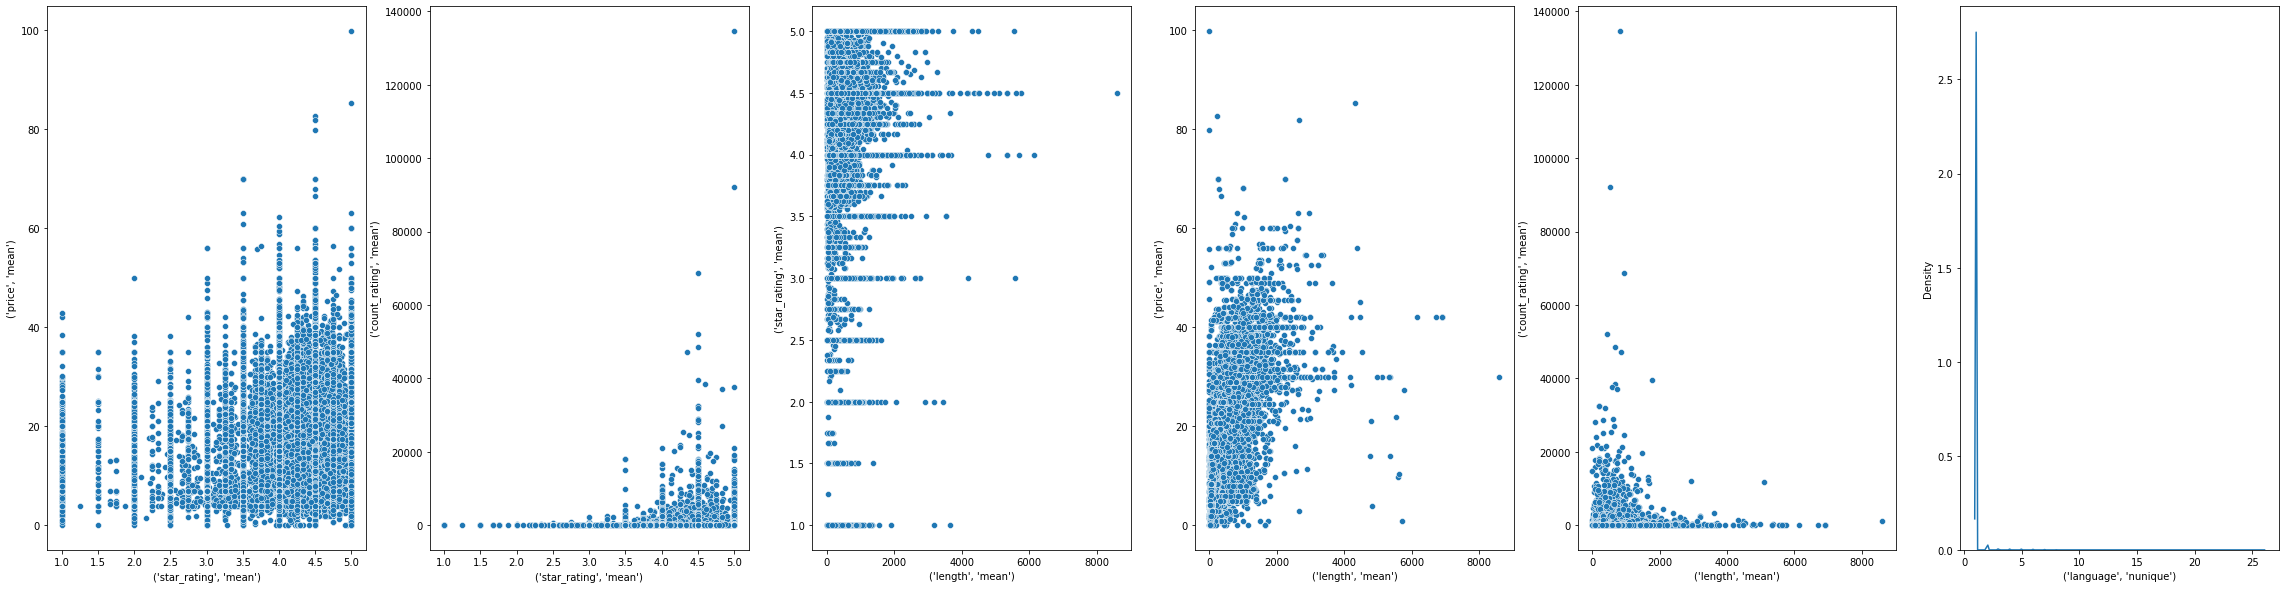

In [252]:
fig, axs = plt.subplots(ncols=6)
fig.set_figwidth(40)
sns.scatterplot(x= ('star_rating','mean'),
                y= ('price','mean'),
                data = auth_stats,
                ax= axs[0])
sns.scatterplot(x= ('star_rating','mean'),
                y= ('count_rating','mean'),
                data = auth_stats,
                ax= axs[1],
              )
sns.scatterplot(x= ('length','mean'),
                y= ('star_rating','mean'),
               data = auth_stats,
                ax= axs[2])
sns.scatterplot(x= ('length','mean'),
                y= ('price','mean'),
               data = auth_stats,
                ax= axs[3])
sns.scatterplot(x= ('length','mean'),
                y= ('count_rating','mean'),
               data = auth_stats,
                ax= axs[4])
sns.kdeplot(x=('language','nunique'),
           data = auth_stats,
           ax = axs[5])

#### Bi-variate EDA: Narrators 

<AxesSubplot:xlabel="('language', 'nunique')", ylabel='Density'>

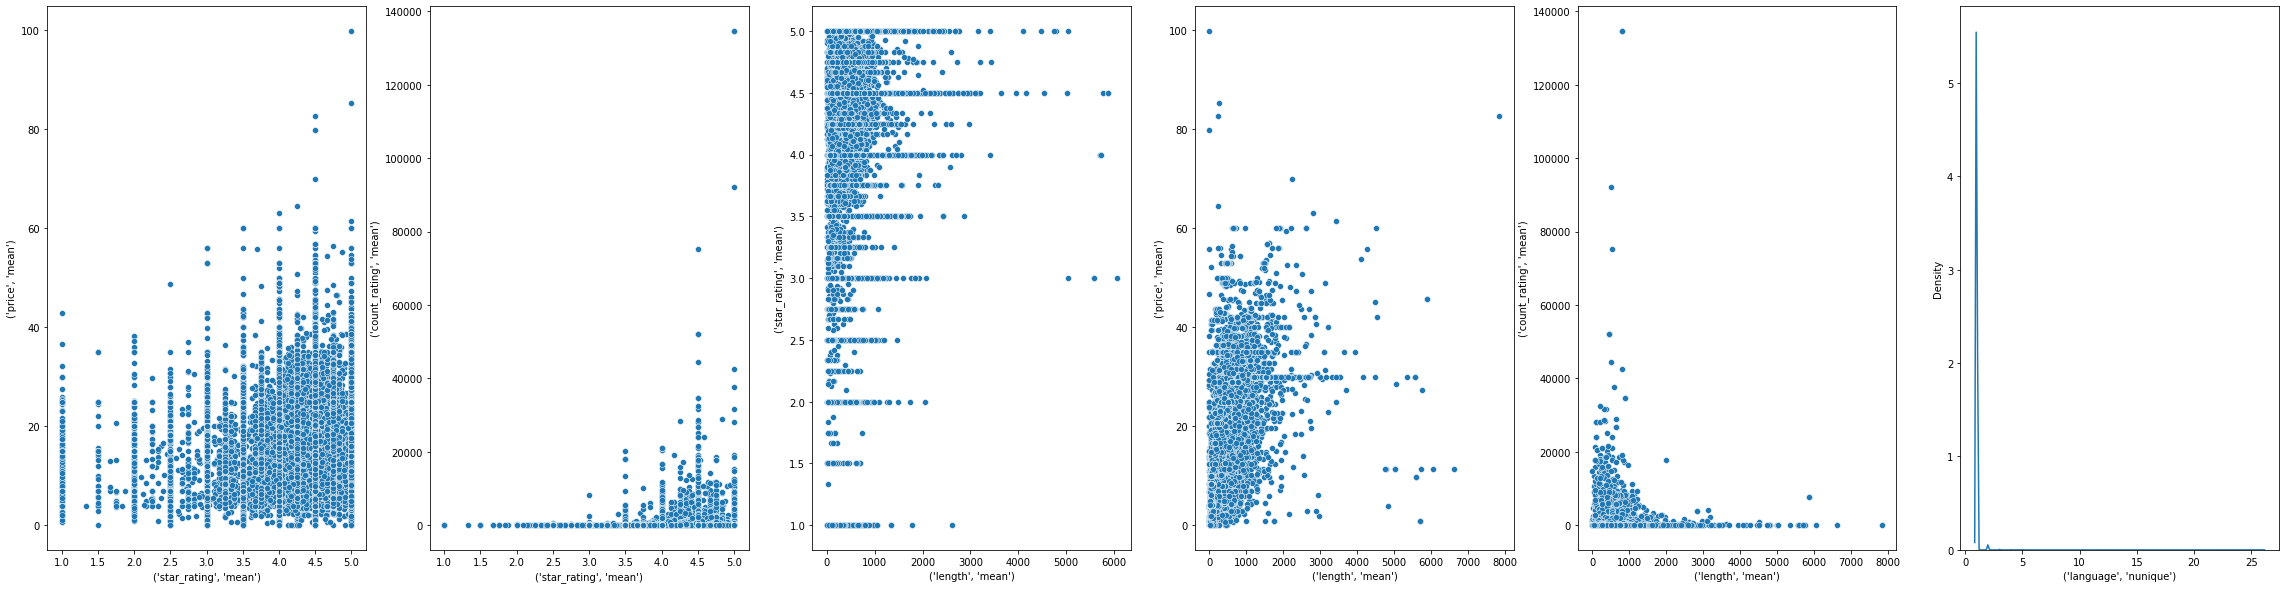

In [253]:
fig, axs = plt.subplots(ncols=6)
fig.set_figwidth(40)
sns.scatterplot(x= ('star_rating','mean'),
                y= ('price','mean'),
                data = narr_stats,
                ax= axs[0])
sns.scatterplot(x= ('star_rating','mean'),
                y= ('count_rating','mean'),
                data = narr_stats,
                ax= axs[1],
              )
sns.scatterplot(x= ('length','mean'),
                y= ('star_rating','mean'),
               data = narr_stats,
                ax= axs[2])
sns.scatterplot(x= ('length','mean'),
                y= ('price','mean'),
               data = narr_stats,
                ax= axs[3])
sns.scatterplot(x= ('length','mean'),
                y= ('count_rating','mean'),
               data = narr_stats,
                ax= axs[4])
sns.kdeplot(x=('language','nunique'),
           data = narr_stats,
           ax = axs[5])

#### Bi-variate EDA: Number of Authors 

<AxesSubplot:xlabel='author', ylabel='category_number'>

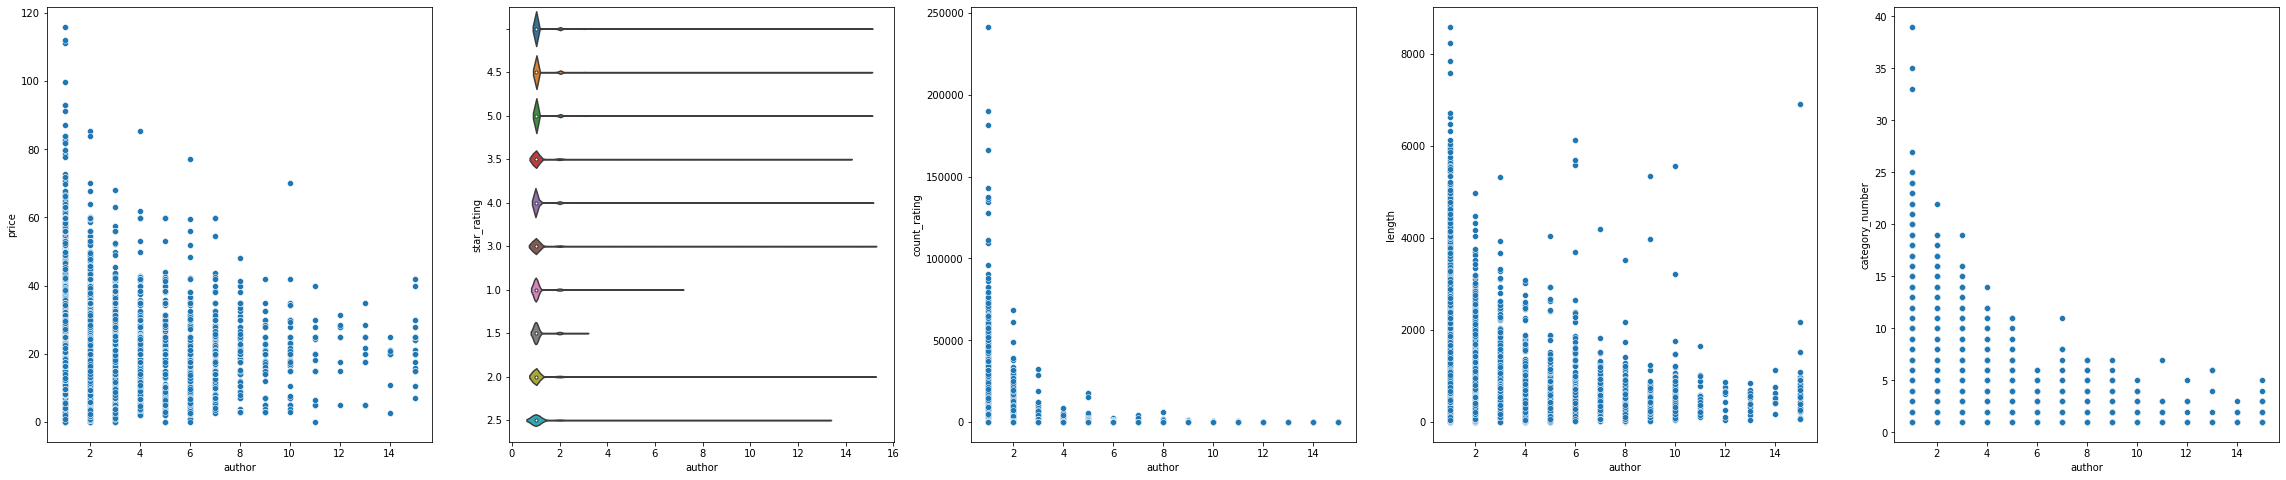

In [104]:
n_author   = titles.author.str.len()

fig, axs = plt.subplots(ncols=5)
fig.set_figwidth(40)
sns.scatterplot(x= n_author,
                y= titles.price,
                ax= axs[0])
sns.violinplot(x= n_author,
                y= titles.star_rating,
                ax= axs[1],
              )
sns.scatterplot(x=n_author,
                y=titles.count_rating,
               data = titles,
                ax= axs[2])
sns.scatterplot(x=n_author,
                y=titles.length,
               data = titles,
                ax= axs[3])
sns.scatterplot(x=n_author,
                y=titles.category_number,
               data = titles,
                ax= axs[4])




#### Bi-variate EDA: Number of Narrators 

<AxesSubplot:xlabel='narrator', ylabel='category_number'>

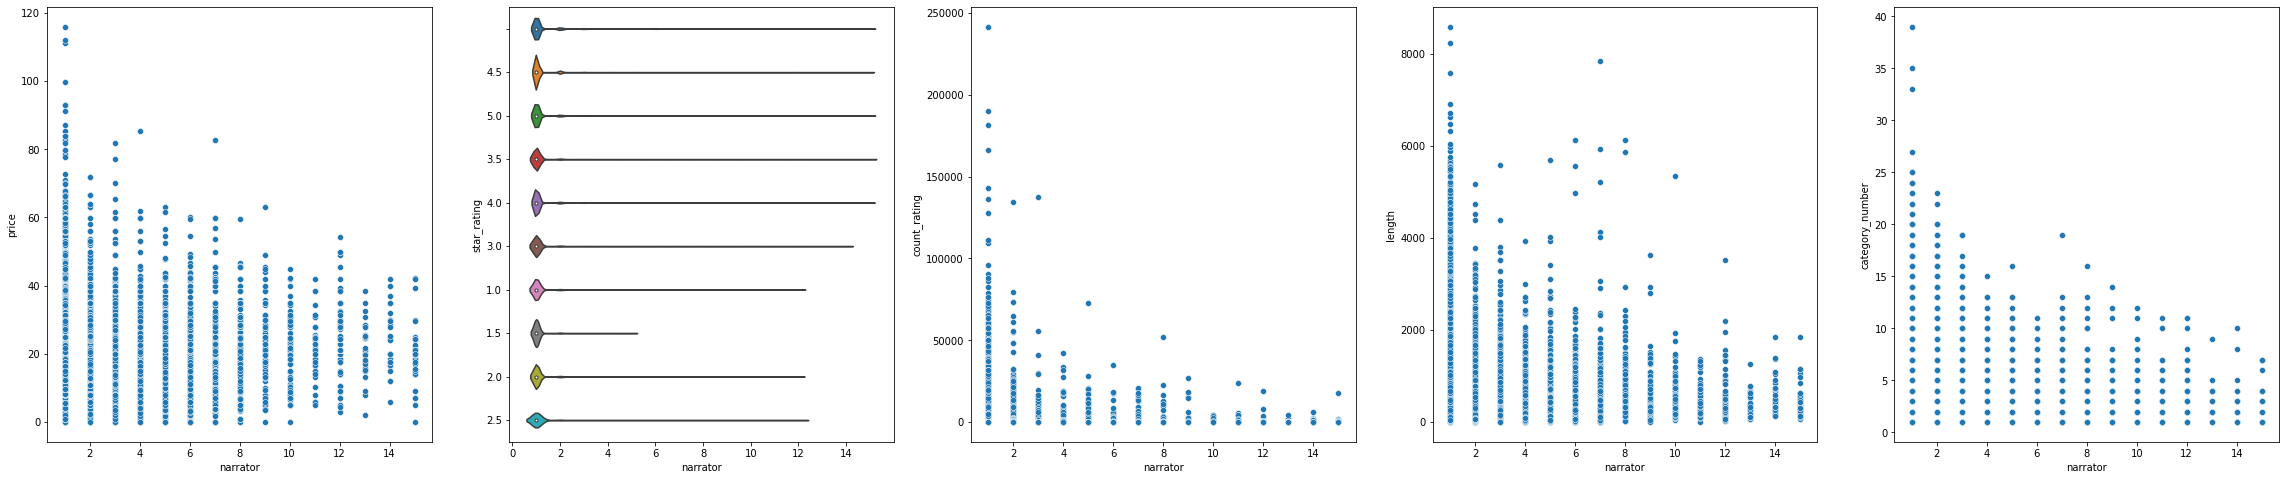

In [105]:
n_narrator = titles.narrator.str.len()

fig, axs = plt.subplots(ncols=5)
fig.set_figwidth(40)
sns.scatterplot(x= n_narrator,
                y= titles.price,
                ax= axs[0])
sns.violinplot(x= n_narrator,
                y= titles.star_rating,
                ax= axs[1],
              )
sns.scatterplot(x=n_narrator,
                y=titles.count_rating,
               data = titles,
                ax= axs[2])
sns.scatterplot(x=n_narrator,
                y=titles.length,
               data = titles,
                ax= axs[3])
sns.scatterplot(x=n_narrator,
                y=titles.category_number,
               data = titles,
                ax= axs[4])

### Author as Narrator <a id='auth_as_narr'></a>

This analysis of Authors and Narrators made it clear that there creators who do both! Interestingly the percentage of Authors as Narrators appears to be growing along with the audible library. The year-over-year growth rate is fairly consistant around 23%, but since this growth rate is lower than the overall library growth rate, they values will diverge.

Better reviews or higher prices might be a draw for more authors to narrate their own material. However this does not seeem to be borne out in the data, price and the rating stars and count are not visably different between the Author narrated and professionally done. 


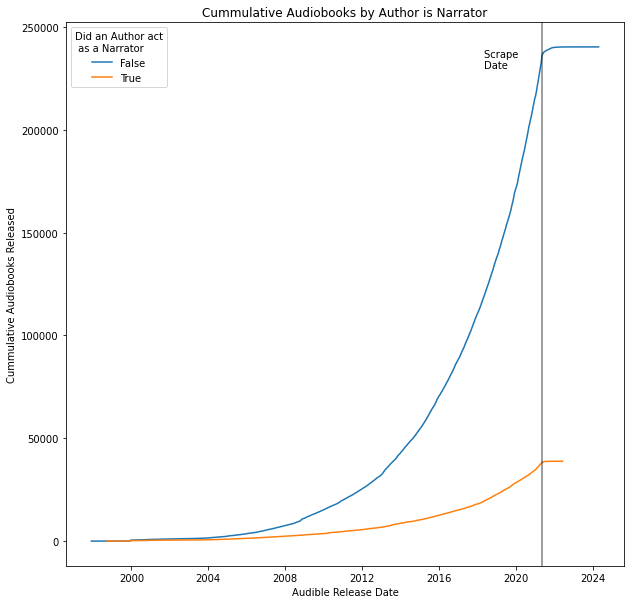

In [14]:
titles['self_narrator'] = list(map(lambda auth,narr: any([x in auth for x in narr]), titles.author,titles.narrator))
titles['cumm_self_nar'] = titles.sort_values('pub_datetime', ascending = True).groupby('self_narrator',dropna=True).cumcount()

plot = sns.lineplot(data= titles, 
             x   = 'pub_datetime', 
             y   = 'cumm_self_nar',
             hue = 'self_narrator',
             ci  = None)

plt.title("Cummulative Audiobooks by Author is Narrator")
plot.set_xlabel("Audible Release Date")
plot.set_ylabel("Cummulative Audiobooks Released")

plot.legend(title = "Did an Author act\n as a Narrator")

plot.axvline(x=pd.to_datetime("2021-05-10"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2018-05-10"),230000, "Scrape \nDate", color ='k')

plt.rcParams['figure.figsize'] = (8,8)


plt.savefig("./graphics/self_narr_timeseries.png", bbox_inches = 'tight')

<ipython-input-16-a3df36003e2e>:22: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(yticks)


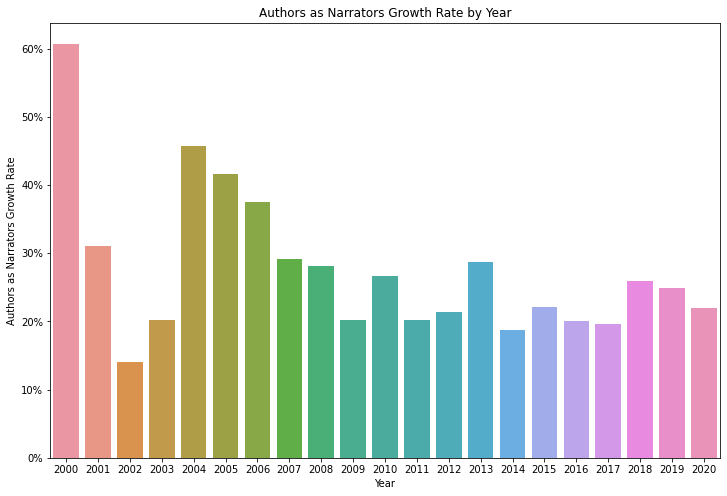

In [16]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
data = titles[titles.self_narrator == True]
years = pd.DatetimeIndex(data.pub_datetime).year
years = years.value_counts().sort_index().drop(labels = [ 2021,2022])
years = np.cumsum(years)

years
diff_y = years.diff().drop(labels = [1998])
years = years.drop(labels = [2020])


perc_change = pd.Series([(x/y)*100 for x, y in list(zip(diff_y, years))],index = diff_y.index)
perc_change = perc_change.drop(labels = [1999])

perc_change
plt.rcParams['figure.figsize'] = (12,8)

plot = sns.barplot(x=perc_change.index, y =perc_change)


yticks = [str(x)+"%" for x in range(0,61,10)]
plot.set_yticklabels(yticks)

plt.title("Authors as Narrators Growth Rate by Year")
plot.set_xlabel("Year")
plot.set_ylabel("Authors as Narrators Growth Rate")

plt.savefig("./graphics/auth_as_narr_growth_rate.png", bbox_inches = 'tight')

The percent of Authors who choose to narrate their own book has been decreasing since Audible's inception but has held roughly constand at 14% for the last decade.

<ipython-input-98-876d9f002140>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(yticks)


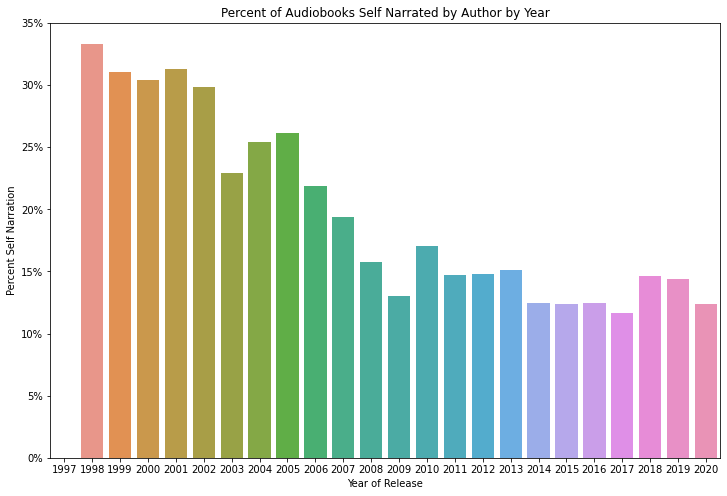

In [98]:
#years = pd.DatetimeIndex(titles.pub_datetime).year

data = titles.groupby(pd.DatetimeIndex(titles.pub_datetime).year).agg({'self_narrator':'mean'})
data = data.drop(labels= [2021,2022,2023,2024])

plot = sns.barplot(x= data.index, 
                   y = 'self_narrator',
                  data = data)

yticks = [str(x)+"%" for x in range(0,36,5)]
plot.set_yticklabels(yticks)

plot.set_xlabel("Year of Release")
plot.set_ylabel("Percent Self Narration")

plot.set_title("Percentage of Audiobooks Self Narrated by Author by Year")

plt.savefig("./graphics/self_narr_perc_overtime.png", bbox_inches = 'tight')

There does not seem to be a clear difference between the author acting as narrator vs another actor, across Price, Length, number of ratings, number of categories, or the star rating distribution.

<AxesSubplot:xlabel='self_narrator', ylabel='star_rating'>

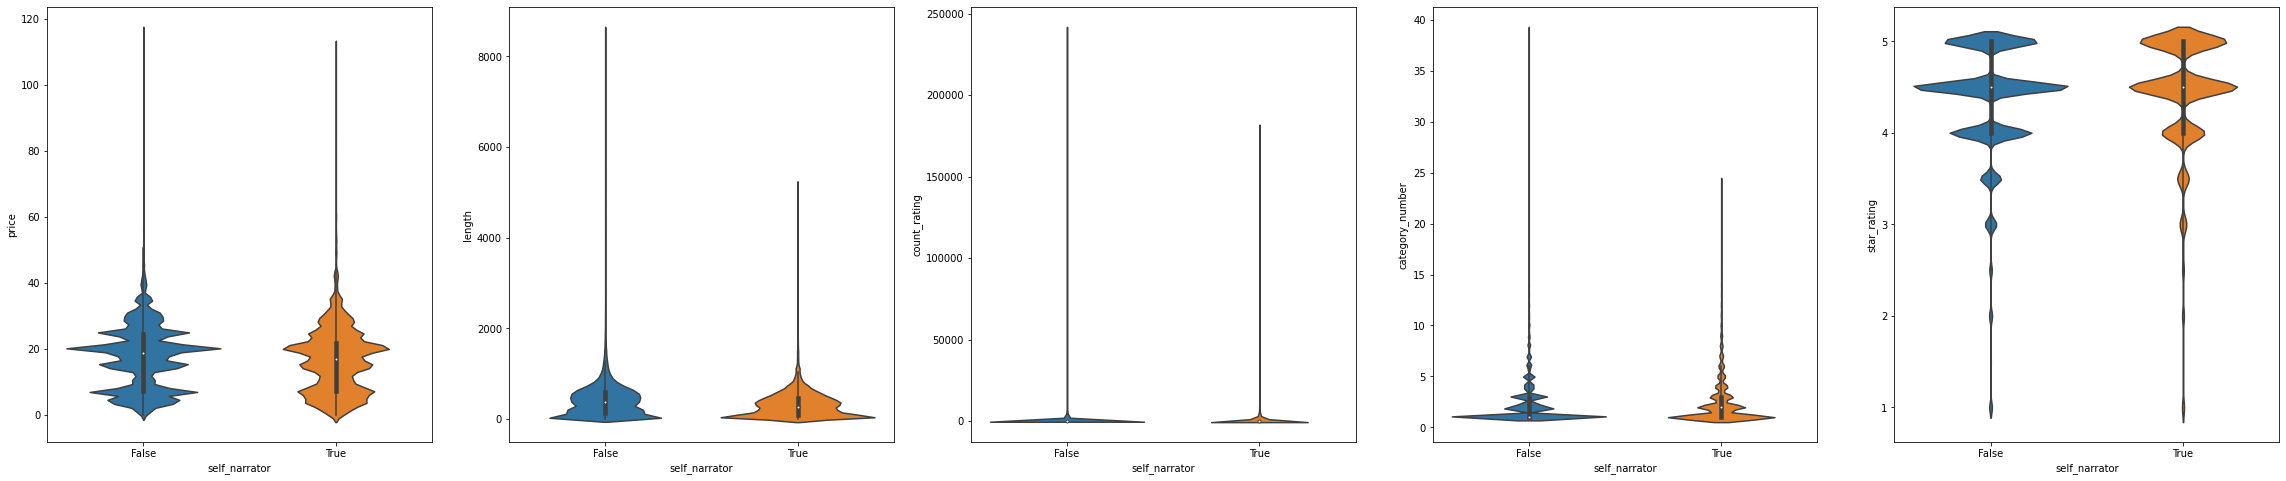

In [46]:
titles['self_narrator'] = list(map(lambda auth,narr: any([x in auth for x in narr]), titles.author,titles.narrator))
fig, axs = plt.subplots(ncols=5)
fig.set_figwidth(40)
sns.violinplot(x='self_narrator',
                y='price',
               data = titles,
                ax= axs[0])
sns.violinplot(x='self_narrator',
                y='length',
               data = titles,
                ax= axs[1])
sns.violinplot(x='self_narrator',
                y='count_rating',
               data = titles,
                ax= axs[2])
sns.violinplot(x='self_narrator',
                y='category_number',
               data = titles,
                ax= axs[3])
sns.violinplot(x=titles['self_narrator'],
                y=titles.star_rating.replace("",np.nan).astype(float),
                ax= axs[4])

#plt.savefig("./graphics/author_narr_comparisons.png", bbox_inches = 'tight')

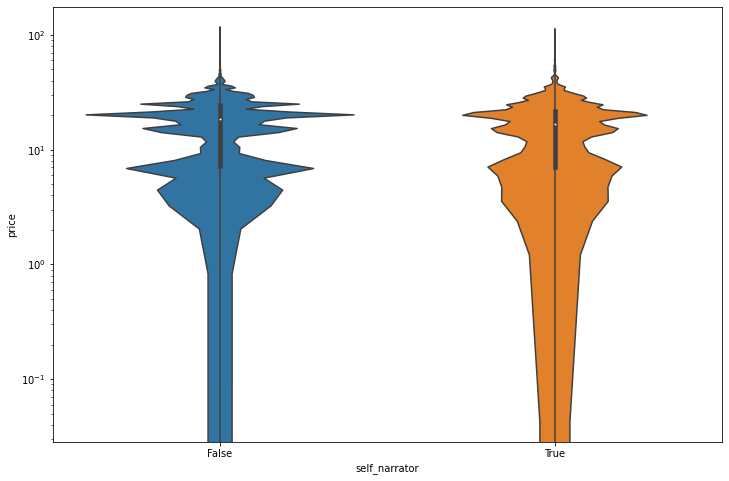

In [149]:
titles['self_narrator'] = list(map(lambda auth,narr: any([x in auth for x in narr]), titles.author,titles.narrator))

sns.violinplot(x='self_narrator',
                y='price',
               data = titles)

plt.yscale('log')

# Languages <a id='lang'></a>
[Back to top](#top)

In [84]:
s         = "There are {} languages represented in Audible's library."
numb_lang = len(titles.language.unique())

print(s.format(numb_lang))

There are 44 languages represented in Audible's library.


A large majority of audiobooks are narrated and avalible in English.

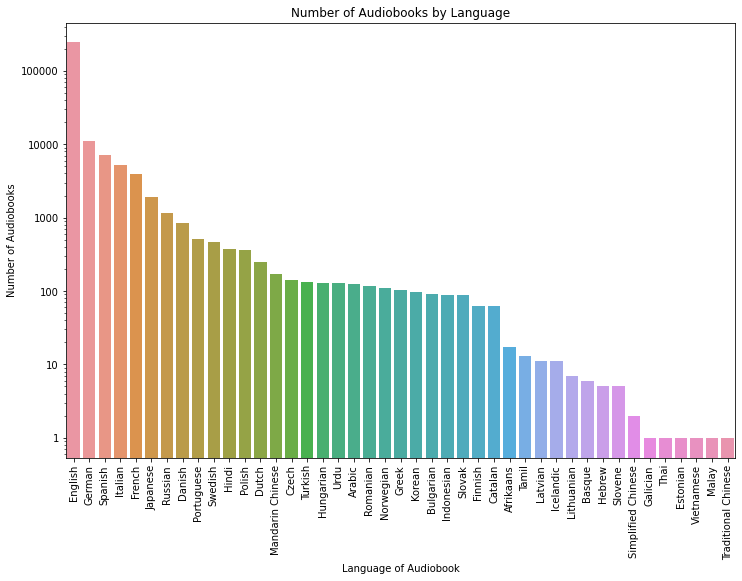

In [85]:
titles['language'] = titles['language'].str.replace("_"," ").str.title()

plot = sns.countplot(x='language', 
                     data = titles, 
                     order = titles['language'].value_counts().index)

plot.set_yscale('log')
plot.set_xlabel("Language of Audiobook")
plot.set_ylabel("Number of Audiobooks")

plt.xticks(rotation =90)
yticks = [1,10,100,1000,10000,100000]
plot.set_yticks(yticks)
plot.set_yticklabels(yticks)

plt.title("Number of Audiobooks by Language")
plt.rcParams['figure.figsize'] = (8,8)

plt.savefig("./graphics/languages.png", bbox_inches = 'tight')

English language audiobooks are the largest language and show no signs of stopping. We can even see the expected releases in the coming years. 

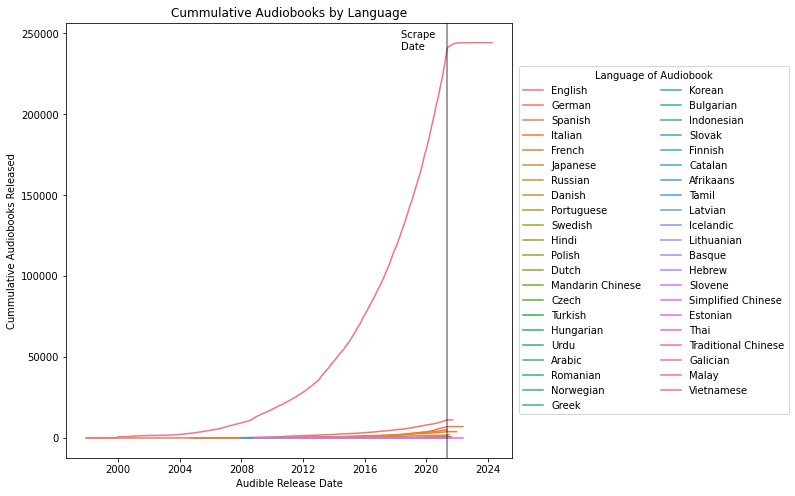

In [81]:
titles['pub_datetime'] = pd.to_datetime(titles.release_date, format='%m-%d-%y')
titles['cumm_lang_pub'] = titles.sort_values('pub_datetime', ascending = True).groupby('language',dropna=True).cumcount()
titles['language'] = titles['language'].str.replace("_"," ").str.title()
lang_order = titles.language.value_counts().sort_values(ascending = False)


plt.rcParams['figure.figsize'] = (8,8)

plot = sns.lineplot(data= titles, 
             x   = 'pub_datetime', 
             y   = 'cumm_lang_pub',
             hue = titles['language'],
             hue_order= lang_order.index,
             ci  = None)

plt.title("Cummulative Audiobooks by Language")
plot.set_xlabel("Audible Release Date")
plot.set_ylabel("Cummulative Audiobooks Released")

plot.legend(title = "Language of Audiobook",
            loc='center right', 
            bbox_to_anchor=(1.63, 0.5), 
            ncol=2)

plot.axvline(x=pd.to_datetime("2021-05-10"),ymin=0,ymax=1, color = 'k',alpha = 0.5)
plot.text(pd.to_datetime("2018-05-10"),240000, "Scrape \nDate", color ='k')

plt.savefig("./graphics/lang_timeseries.png", bbox_inches = 'tight')

English accounts for 87% of all titles and languages covered by ACX account for 95% of audibles titles. Most likely because the ACX service was used in their production.

In [47]:
total_titles = titles.shape[0]
titles_by_lang = (titles.value_counts("language")).sort_values(ascending=False)
percent_titles = (titles_by_lang / total_titles*100).sort_values(ascending=False)

print('\nNumber of titles by language')
print(titles_by_lang[0:5])

print('\nPercent of titles by language')
print(percent_titles[0:5])

print('\nPercent Covered by ACX Producers (English, German, Spanish, French) {:.1f}'.format(percent_titles[['English','French','German','Spanish']].sum()))


Number of titles by language
language
English    244156
German      11195
Spanish      7082
Italian      5165
French       3932
dtype: int64

Percent of titles by language
language
English    87.452809
German      4.009872
Spanish     2.536660
Italian     1.850021
French      1.408380
dtype: float64

Percent Covered by ACX Producers (all languages) 95.4


# Length Distribution <a id='length'></a>
[Back to top](#top)

A [y combinator blog](https://news.ycombinator.com/item?id=27108326) poster mentioned that audiobooks > 3 hours in length get a royalty rate compared to shorter books, depending on how lucrative the deal is, we should be able to observe this in the data, and we do! Approaching the three hour mark we see fewer books as then a spike right after 3 hours, then the value decays back to normal. We see a similar trend around the 5 hour mark, however adding more bins makes the effect less apparent. 

In [124]:
titles.sort_values("length")

,title_url,author,language,narrator,pod_flag,price,subtitle,title,release_date,length,star_rating,count_rating,title_category,category_number,pub_datetime,cumm_lang_pub,self_narrator,cumm_self_nar,acx_bin
236789,https://www.audible.com/pd/The-Power-of-Hope-A...,[Kate Garraway],English,[Kate Garraway],False,28.35,The Moving Memoir from ITV’s Kate Garraway,The Power of Hope,05-13-21,0,NaN,0.0,"[Adventurers, Explorers & Survival]",1,2021-05-13,240430,True,38456,Under 1 Hour
169969,https://www.audible.com/pd/Rationality-Audiobo...,[Steven Pinker],English,[],False,34.90,"What It Is, Why It Seems Scarce, Why It Matters",Rationality,09-28-21,0,NaN,0.0,"[Social Psychology & Interactions, Mathematics]",2,2021-09-28,243184,False,239407,Under 1 Hour
11278,https://www.audible.com/pd/About-Time-Audioboo...,[David Rooney],English,[],False,28.35,A History of Civilization in Twelve Clocks,About Time,06-17-21,0,NaN,0.0,"[History, History & Culture, History, History ...",4,2021-06-17,241661,False,237923,Under 1 Hour
245817,https://www.audible.com/pd/The-Supreme-Court-A...,[Alison Gash],English,[Alison Gash],False,13.99,An Up-to-the-Minute Presentation,The Supreme Court,08-17-21,0,NaN,0.0,"[Revolution & Founding, Judicial Systems]",2,2021-08-17,242641,True,38767,Under 1 Hour
22056,https://www.audible.com/pd/Ashtons-Dancing-Dre...,"[Kaitlyn Pitts, Camryn Pitts, Olivia Pitts]",English,[],False,20.52,,Ashton's Dancing Dreams,10-05-21,0,NaN,0.0,"[Dance, Performing Arts, Religious Fiction, Mu...",4,2021-10-05,243284,False,239497,Under 1 Hour
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
186866,https://www.audible.com/pd/Slave-Narratives-Me...,"[Solomon Northrup, Booker T. Washington, Frede...",English,[Museum Audiobooks cast],False,41.99,"Twelve Years a Slave, Up From Slavery, Life an...",Slave Narratives Mega Collection: 18 of the Mo...,01-22-21,6908,NaN,0.0,"[African American, United States, Americas]",3,2021-01-22,223001,False,218814,More than 20 Hours
213554,https://www.audible.com/pd/The-Decline-and-Fal...,[Edward Gibbon],English,[Charlton Griffin],False,39.95,,The Decline and Fall of the Roman Empire,04-21-15,7591,4.5,646.0,"[Rome, Ancient History, Civilization, World, H...",5,2015-04-21,63972,False,58854,More than 20 Hours
24454,https://www.audible.com/pd/Audiobook/B08M18NFHW,[夏目 漱石],Japanese,"[佐々木 健, 西村 健志, 野口 晃, 渡辺 知明, 蘇武 健治, 中島 定吉, 城山 森人]",False,82.73,,夏目漱石名作集,12-22-20,7846,NaN,0.0,[Asian],1,2020-12-22,1684,False,215520,More than 20 Hours
3628,https://www.audible.com/pd/705-Audiobook/B07JY...,[小川 未明],Japanese,[パンローリング],False,41.36,,小川未明童話全集（全705話）,02-28-18,8249,NaN,0.0,[Asian],1,2018-02-28,937,False,114585,More than 20 Hours


median: 5.87
mean: 6.64


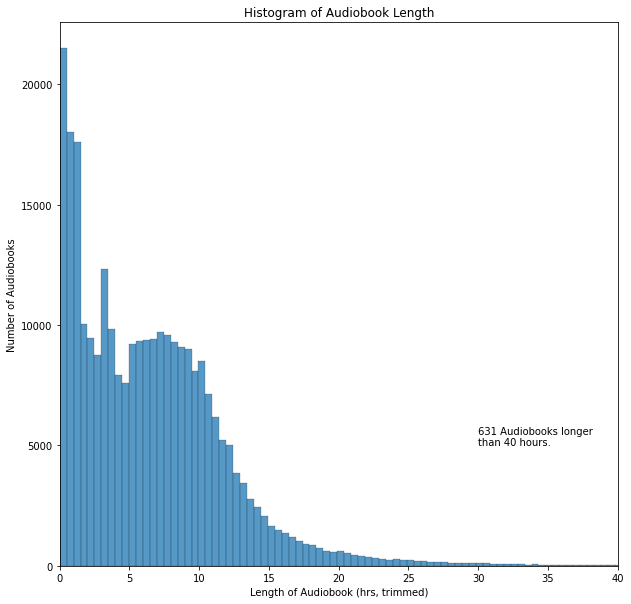

In [8]:
plt.rcParams['figure.figsize'] = (10,10)

plot = sns.histplot(x = (titles.length/60),bins = 288)

plot.set_xlabel("Length of Audiobook (hrs, trimmed)")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Audiobook Length")
plt.xlim(0,40)

#plot.axvline(x=3, ymin=0,ymax=1, color = 'k')
#plt.text(x=4, y=20000, s= "3 Hours", color = 'k')

plt.text(x=30, y=5000, s= "{} Audiobooks longer\nthan 40 hours.".format(titles[titles.length>2400].shape[0]), color = 'k')

plt.savefig("./graphics/hist_length.png", bbox_inches = 'tight')

print("median: {:.2f}".format(titles.length.median()/60))
print("mean: {:.2f}".format(titles.length.mean()/60))

#top 3 longest.
#All DEAD
#https://www.audible.com/pd/All-DEAD-Audiobook/B07YF3XH93
#Natsume Soseki Masterpiece Collection
#https://www.audible.com/search?keywords=%E5%A4%8F%E7%9B%AE%E6%BC%B1%E7%9F%B3%E5%90%8D%E4%BD%9C%E9%9B%86&ref=a_search_t1_header_search
#Complete Works of Mimei Ogawa Fairy Tales
#https://www.audible.com/pd/705-Audiobook/B07JY9D1Q7?qid=1621966151&sr=1-1&ref=a_search_c3_lProduct_1_1&pf_rd_p=83218cca-c308-412f-bfcf-90198b687a2f&pf_rd_r=W7X2DH66FXW439HDZW9G

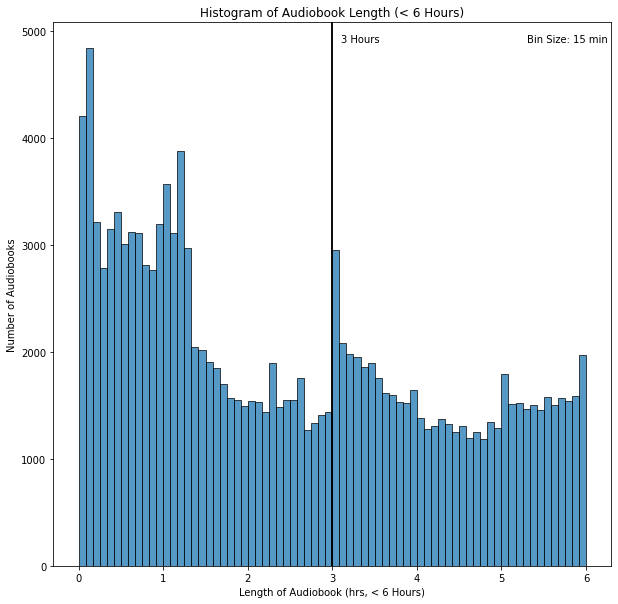

In [12]:
data = titles[(titles.length/60) <= 6]['length']/60
plot = sns.histplot(x =data, bins = 72)

plot.set_xlabel("Length of Audiobook (hrs, < 6 Hours)")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Audiobook Length (< 6 Hours)")

plot.axvline(x=3, ymin=0,ymax=1, color = 'k')
plt.text(x=3.1, y=4900, s= "3 Hours", color = 'k')

plot.axvline(x=3, ymin=0,ymax=1, color = 'k')
plt.text(x=5.3, y=4900, s= "Bin Size: 15 min", color = 'k')

plt.savefig("./graphics/hist_under_6.png", bbox_inches = 'tight')

# Price Distribution <a id='price'></a>
[Back to top](#top)

Prices in the Audible library work a bit differently from every other marketplace. Since most customers are subscribers using credits and not buying audiobooks a la carte, the consumer interacts with the price in a non-standard way. After the initial "investment" in a subscription, consumers views the consumption (buying the book with credits) [as free or extra](https://kenthendricks.com/audible-pricing/). Additonally, the time seperation between the purchase of the subscription (once then in the background renewing) and the buying of the book via credits creates a feeling of low stakes and 'costless' consumption.

This makes the pricing of books more about signaling than the market rate. However we can still pull out insights.

Even with the credits system, Audible lists almost all books at a dollar value + 95 cents. A common pricing strategy to make the product appear cheaper. The most common prices also fall along common break points, ~\\$20, \\$7, \\$15, \\$4, $25, etc.

60% of audiobooks fall above the Audible membership price of $14.95.

There are 2539 audiobooks greater than $40.


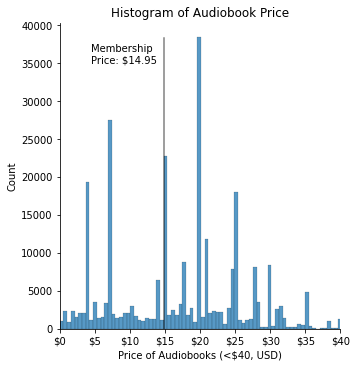

In [65]:
plot = sns.displot(titles.price, kind = 'hist')

plt.axvline(14.90, 0, 0.95, color = 'k', alpha = 0.5) # price adjusted for visual clarity
plt.text(x=4.5, y=35000, s= "Membership \nPrice: $14.95", color = 'k')

plot.set_axis_labels("Price of Audiobooks (<$40, USD)")
plt.title("Histogram of Audiobook Price")

plt.xlim(0,40)

xticks = ["$"+str(x) for x in range(0,41,5)]
plot.set_xticklabels(xticks)

plt.savefig("./graphics/hist_price.png", bbox_inches = 'tight')

print("There are {} audiobooks greater than $40.".format(titles[titles.price>40].shape[0]))

In [93]:
price_str = titles['price'].astype(str).apply(lambda x: "$"+x)
price_str = price_str.groupby(price_str).size().sort_values(ascending= False)[0:10].to_frame()
price_str.columns = ['Number of Books']

print("Median Price: {}".format(titles.price.astype(str).median()))
print("Most Common Prices for audiobooks")
price_str

Median Price: 18.16
Most Common Prices for audiobooks


,Number of Books
price,
$19.95,35103
$6.95,24551
$14.95,22088
$3.95,16837
$24.95,15953
$17.49,7144
$20.99,6818
$27.99,4211
$29.95,4060


There are 158886 Audiobooks more expensive than the $14.95 membership fee.
There are 120416 Audiobooks cheaper than the $14.95 membership fee.
56.9% of audiobooks are more expensive than the membership


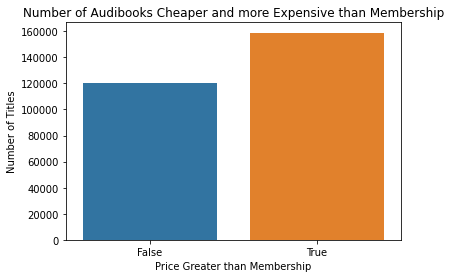

In [110]:
price_split = titles.price.groupby(titles.price>14.95).size().to_frame()

s1 = "There are {} Audiobooks more expensive than the $14.95 membership fee."
s2 = "There are {} Audiobooks cheaper than the $14.95 membership fee."

print(s1.format(price_split.loc[True]['price']))
print(s2.format(price_split.loc[False]['price']))
print("{:.1f}% of audiobooks are more expensive than the membership".format((price_split.loc[True]['price'] / titles.shape[0])*100))

plot = sns.barplot(x = price_split.index, y = price_split.price)                
plot.set(xlabel="Price Greater than Membership", ylabel = "Number of Titles")

plt.title("Number of Audibooks Cheaper and more Expensive than Membership")

plt.savefig("./graphics/price_membership.png", bbox_inches = 'tight')

# Length by Price <a id='price_length'></a>
[Back to top](#top)

A priori, price and length are likely closely linked. Longer books are more expensive to write, marginally more expensive to manufacture, and audio-dubbing costs increase linearly with length. 

A density plot of Length and Price shows a loose but direct relationship with 4 strong local maximas. 

Further research into price releaved an [article on ACX](https://help.acx.com/s/article/can-i-set-my-pricing) suggesting that each retailer independently and discretionarily sets audiobooks prices. As length increases so does price,  up to \\$25-\\$30 for audiobooks over 20 hours. 

This effect can be seen just by examining the 5 most common prices. However, using the categorizations provided by ACX creates a much clearer image with distinct peaks representing each a price and length range.

<ipython-input-35-a5de3a3244b2>:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(yticks)


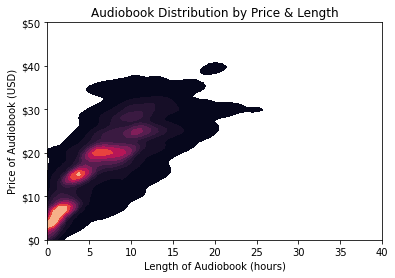

In [35]:
# Warning, takes a while to render

plot = sns.kdeplot(x =(titles.length/60), 
                   y = titles.price,
                   cmap = 'rocket',
                   fill = True)

plt.xlim(0,40)
plt.ylim(0,50)

plt.ylabel("Price of Audiobook (USD)")
plt.xlabel("Length of Audiobook (hours)")
plt.title("Audiobook Distribution by Price & Length")


yticks = ["$"+str(x) for x in range(0,51,10)]
plot.set_yticklabels(yticks)

plt.savefig("./graphics/price_vs_length.png", bbox_inches = 'tight')

price
3.95      0.083333
6.95      1.016667
14.95     3.000000
19.95     5.016667
24.95    10.016667
Name: length, dtype: float64


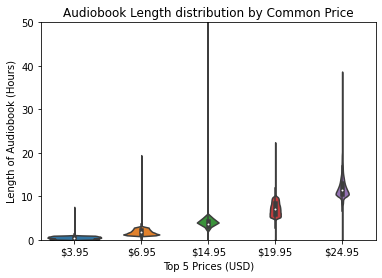

In [180]:
price_common = titles[titles.count_rating >= 1].groupby('price').size().sort_values(ascending= False).index.values[0:5]

data = titles[[x in price_common for x in titles.price]]
price_str = data.price.sort_values(ascending = True).astype(str).apply(lambda x: "$"+x)

print(data.groupby('price').length.agg(mode)/60)



plot = sns.violinplot(x= price_str, y = data.length/60)

plot.set_ylabel("Length of Audiobook (Hours)")
plot.set_xlabel("Top 5 Prices (USD)")
plot.set_title("Audiobook Length distribution by Common Price")

plt.ylim(0,50)


plt.savefig("./graphics/common_prices.png", bbox_inches = 'tight')

In [104]:
def acx_pricing_lookup(length):
    if length < 1:
        return "Under 1 Hour"
    elif 1 <= length < 3 :
        return "1-3 Hours"
    elif 3 <= length < 5 :
        return "3-5 Hours"
    elif 5 <= length < 10 :
        return "5-10 Hours"
    elif 10 <= length < 20 :
        return "10-20 Hours"
    elif 20 <= length :
        return "More than 20 Hours"

    
    
titles['acx_bin'] = (titles.length/60).apply(acx_pricing_lookup)

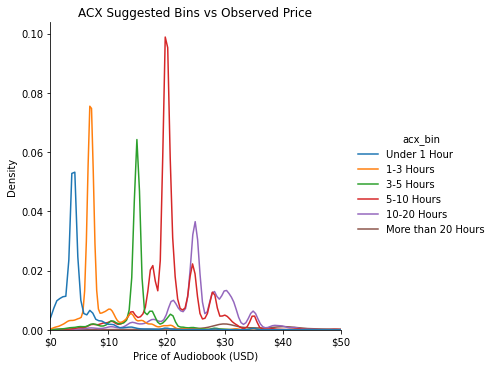

In [63]:
plot = sns.displot(x=titles.price, kind = 'kde', hue = titles.acx_bin ,hue_order=["Under 1 Hour", "1-3 Hours","3-5 Hours","5-10 Hours","10-20 Hours","More than 20 Hours"])

plt.xlabel("Price of Audiobook (USD)")
plt.title("ACX Suggested Bins vs Observed Price")

plt.xlim(0,50)

xticks = ["$"+str(x) for x in range(0,51,10)]
plot.set_xticklabels(xticks)

plt.savefig("./graphics/acx_price_hist.png", bbox_inches = 'tight')

acx_bin
Under 1 Hour           3.95
1-3 Hours              6.95
3-5 Hours             14.95
5-10 Hours            19.95
10-20 Hours           24.95
More than 20 Hours    31.18
Name: price, dtype: float64


<ipython-input-67-de69027558bf>:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(yticks)


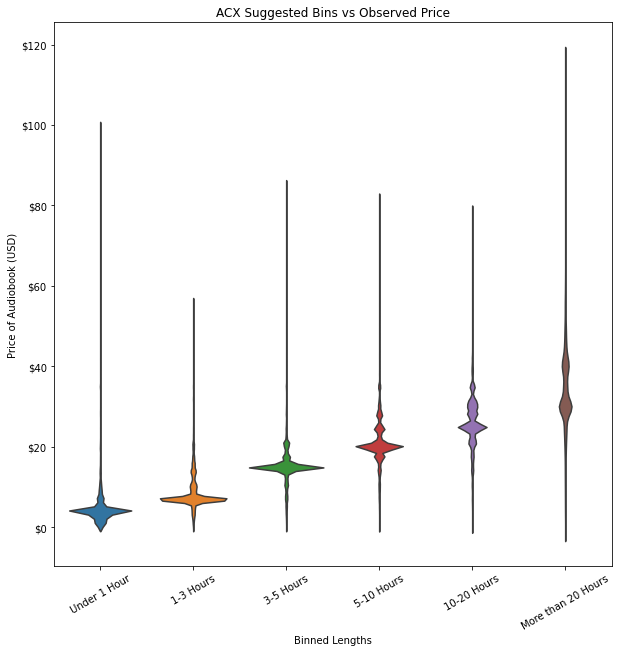

In [67]:
plot = sns.violinplot(x = titles.acx_bin, y = titles.price, inner = None,
                      order=["Under 1 Hour","1-3 Hours","3-5 Hours","5-10 Hours","10-20 Hours","More than 20 Hours"])

plot.set_ylabel("Price of Audiobook (USD)")
plot.set_xlabel("Binned Lengths")
plot.set_title("ACX Suggested Bins vs Observed Price")

plt.xticks(rotation =30)

yticks = ["$"+str(x) for x in range(-20,121,20)]
plot.set_yticklabels(yticks)

plt.savefig("./graphics/acx_price_bins.png", bbox_inches = 'tight')

print(titles.groupby('acx_bin').price.median().sort_values())

## Inter-group differences
[Back to top](#top)

For books grouped into the 5-10 hour or 10-20 hour groups, what is the difference between the \\$19.95, \\$24.95, and \\$27.95 price points?

<ipython-input-246-8f1c753caa80>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['price'] = ["$"+str(x) for x in data.price]
<ipython-input-246-8f1c753caa80>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['star_rating'] = data.star_rating.replace("",np.nan).astype(float)


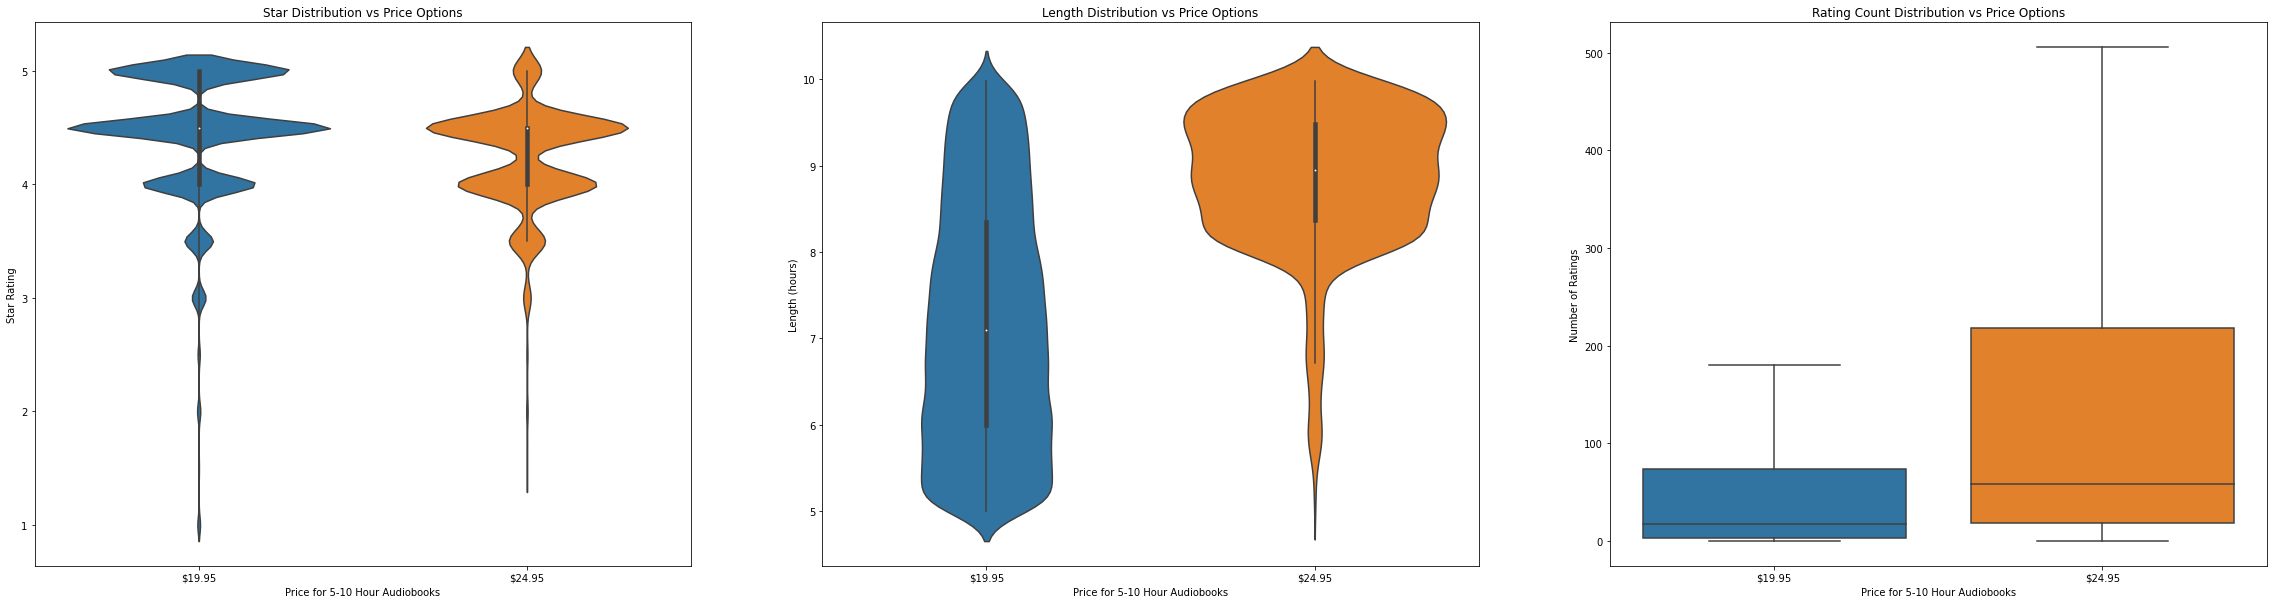

In [246]:
titles['acx_bin'] = (titles.length/60).apply(acx_pricing_lookup)

data = titles[(titles.acx_bin == '5-10 Hours') & ((titles.price == 19.95 ) | (titles.price == 24.95 ))]
data['price'] = ["$"+str(x) for x in data.price]
data['star_rating'] = data.star_rating.replace("",np.nan).astype(float)

fig, axs = plt.subplots(ncols=3)
fig.set_figwidth(40)
sns.violinplot(x= data.price ,
               y= data.star_rating,
                data = data,
                ax= axs[0])
sns.violinplot(x= data.price.astype(str) ,
               y= data.length/60,
                data = data,
                ax= axs[1])
sns.boxplot(x= data.price.astype(str) ,
               y= data.count_rating,
                data = data,
                showfliers = False,
                ax= axs[2])


axs[0].set_title("Star Distribution vs Price Options")
axs[1].set_title("Length Distribution vs Price Options")
axs[2].set_title("Rating Count Distribution vs Price Options")

axs[0].set_ylabel("Star Rating")
axs[1].set_ylabel("Length (hours)")
axs[2].set_ylabel("Number of Ratings")

axs[0].set_xlabel("Price for 5-10 Hour Audiobooks")
axs[1].set_xlabel("Price for 5-10 Hour Audiobooks")
axs[2].set_xlabel("Price for 5-10 Hour Audiobooks")

plt.savefig("./graphics/price_diff_comparison.png", bbox_inches = 'tight')


# Bang for your Buck <a id='band4buck'></a>
[Back to top](#top)

Another way of thinking about price and length is as a 'bang for your buck' or how much content a dollar buys you. Though, as you might expect of a subscription service star rating and the number of reviews doesnt seem to be effected by the 'hours per dollar' metric. (count rating vs hr_per_USD is not shown, data follows axis heavily).

In [125]:
data         = titles[(titles[['price','length']].notnull().all(1)) & (titles.length > 0) & (titles.star_rating != "") & (titles.price != 0)]
hr_per_USD   = (data.length/60) / (data.price)
star_order   = [str(x/2) for x in list(range(2,11,1))]
star_order.reverse()

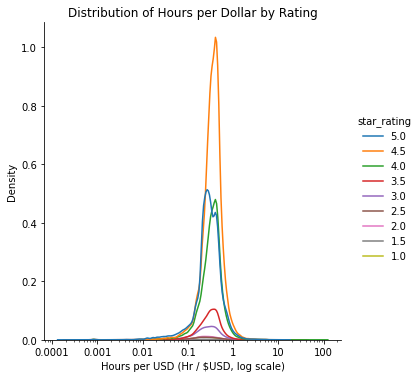

In [91]:
plot = sns.displot(x = hr_per_USD, hue= data.star_rating, log_scale= True, kind = 'kde', legend = True, hue_order=star_order)

plt.xlabel("Hours per USD (Hr / $USD, log scale)")
plt.title("Distribution of Hours per Dollar by Rating")

xticks = [0.0001,0.001,0.01,0.1,1,10,100]
plt.xticks(xticks,xticks)

plt.savefig("./graphics/hours_per_USD_dist.png", bbox_inches = 'tight')




KeyboardInterrupt: 

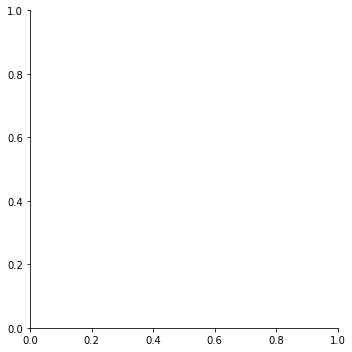

In [126]:
plot = sns.displot(x = hr_per_USD, y = data.count_rating, hue= data.star_rating, kind = 'kde', legend = True, hue_order=star_order)


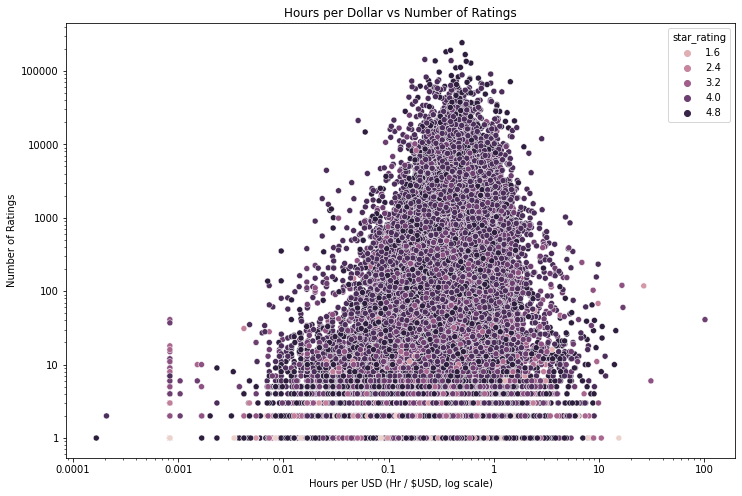

In [144]:
plot = sns.scatterplot(x = hr_per_USD,y = data.count_rating, hue= data.star_rating, 
                       #log_scale= True, kind = 'kde', 
                       legend = True, hue_order=star_order)
plot.set_yscale('log')
plot.set_xscale('log')


plot.set_xlabel("Hours per USD (Hr / $USD, log scale)")
plot.set_ylabel("Number of Ratings")
plot.set_title("Hours per Dollar vs Number of Ratings")

xticks = [0.0001,0.001,0.01,0.1,1,10,100]
plt.xticks(xticks,xticks)

yticks = [1,10,100, 1000, 10000, 100000]
plt.yticks(yticks,yticks)

plt.savefig("./graphics/hours_per_USD_vs_countrating.png", bbox_inches = 'tight')


# Reviews & Ratings <a id='reviews'></a>
[Back to top](#top)

Reviews as one might expect follows an right-skewed distribution with the most common number of reviews being 0. The median is 11 while the mean is 245 suggesting some extreme outliers. 

Those outliers tend to be books you might have heard of such as *Ready Player One*, *Where the Crawdads Sing* and *Born a Crime*. Interestingly, the first and last are books I sought out with my Audible subscription. *Ready Player One* was one of the first books I listened to on Audible and *Born a Crime* followed not long after. 

While researching the title & subtitle length, I discovered an interesting phenomenon with reviews. A single author, who happens to use really long titles, has the same number of reviews on all her books and each book has a 5 star rating. Looking at the Audible page while there are 200 five-star ratings on each book, there are no written reviews. Possibly a pay for reviews scam but without review level scraping, it is difficult to know for certain.

There are 63645 audiobooks without a review
Median: 11.00
Mean: 245.14


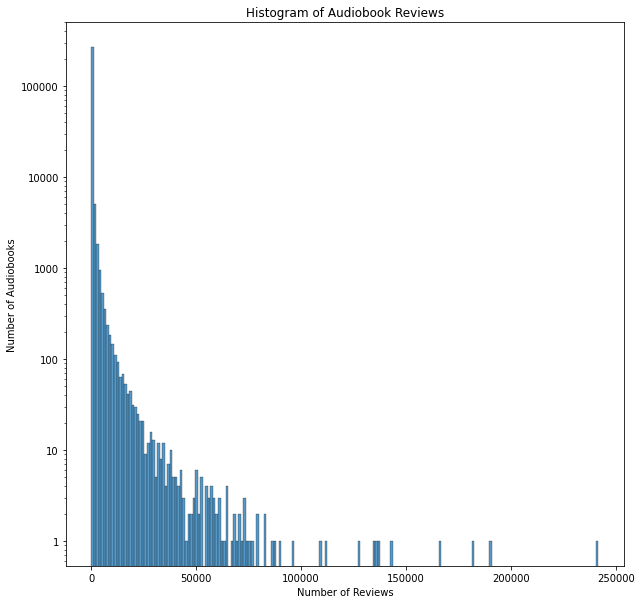

In [75]:
plot = sns.histplot(x = titles.count_rating, bins = 200)

plot.set_xlabel("Number of Reviews")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Audiobook Reviews")
plot.set_yscale('log')

yticks = [1,10,100,1000,10000,100000]
plot.set_yticks(yticks)
plot.set_yticklabels(yticks)

print("There are {} audiobooks without a review".format(titles.loc[(titles.release_date <= '2021-05-10') & (titles.count_rating == 0)].shape[0]))
plt.savefig("./graphics/hist_reviews.png", bbox_inches = 'tight')

print("Median: {:.2f}".format(titles.count_rating.median()))
print("Mean: {:.2f}".format(titles.count_rating.mean()))

Most rated titles, and some spousal competition.

In [262]:
titles.sort_values('count_rating', ascending=False)[0:4][['author','narrator','language','title','subtitle','price','star_rating','count_rating','release_date']]

,author,narrator,language,title,subtitle,price,star_rating,count_rating,release_date
170312,[Ernest Cline],[Wil Wheaton],English,Ready Player One,,31.50,5.0,241735.0,08-16-11
271379,[Delia Owens],[Cassandra Campbell],English,Where the Crawdads Sing,,31.50,5.0,190374.0,08-14-18
35431,[Trevor Noah],[Trevor Noah],English,Born a Crime,Stories from a South African Childhood,24.95,5.0,181458.0,11-15-16
28363,[Michelle Obama],[Michelle Obama],English,Becoming,,35.71,5.0,166488.0,11-13-18


In [261]:
#some difference between the spouses
titles[titles.title == 'A Promised Land'].head(1)[['author','narrator','language','title','subtitle','price','star_rating','count_rating','release_date']]

,author,narrator,language,title,subtitle,price,star_rating,count_rating,release_date
8469,[Barack Obama],[Barack Obama],English,A Promised Land,,54.54,5.0,529.0,11-17-20


## Identical Rating numbers as sign of pay-for-reviews?

In [258]:
#pd.set_option('display.max_colwidth', None)
titles['title_length'] = titles.title.str.split().str.len() 
titles.sort_values('title_length', ascending = False).head(3)[['author','narrator','language','title','subtitle','price','star_rating','count_rating','release_date']]

# weirdly the counts are the same?
# similar release date

,author,narrator,language,title,subtitle,price,star_rating,count_rating,release_date
92732,[Giselle Johnson],[Keymer Roa],Spanish,Guía de Viaje económica de Tailandia: Tips ese...,,6.95,5.0,200.0,01-17-20
92733,[Giselle Johnson],[Keymer Roa],Spanish,Guía de Viaje económica de Tailandia: Tips ese...,,6.95,5.0,200.0,01-14-20
92724,[Giselle Johnson],[Keymer Roa],Spanish,Guía de Viaje económica de Alemania: Tips esen...,,6.95,5.0,200.0,01-14-20


## Star Rating

Star ratings show the common left-skew with most books achieving a 4.5 star rating. With 10s of books getting 1, 1.5 or 2 stars.  

There does seem to be increases in the average number of ratings and the price for audiobooks rated as 4.5 stars. However this is expected as popular books are likely priced higher, get more reviews, and are likely rated as 4.5 rather than 5 stars. 

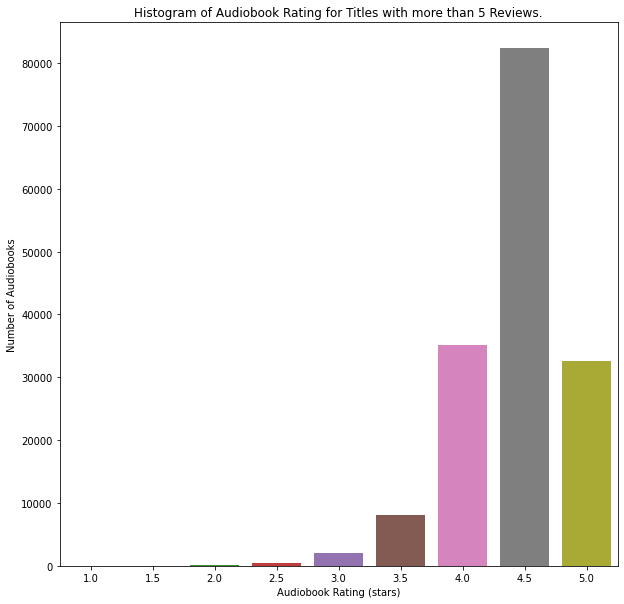

In [130]:
plot = sns.countplot(x = titles[titles.count_rating > 5]['star_rating'],order=['1.0','1.5','2.0','2.5','3.0','3.5','4.0','4.5','5.0'])

plot.set_xlabel("Audiobook Rating (stars)")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Audiobook Rating for Titles with more than 5 Reviews.")

plt.savefig("./graphics/hist_stars.png", bbox_inches = 'tight')

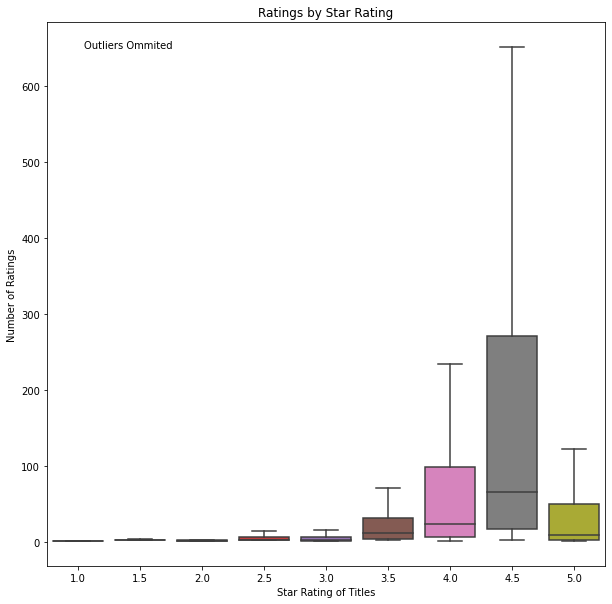

In [131]:
star_order   = [str(x/2) for x in list(range(2,11,1))]
star_order

plot = sns.boxplot(x=titles.star_rating,
           y=titles.count_rating, order = star_order, 
            showfliers = False
           )

plt.xlabel("Star Rating of Titles")
plt.ylabel("Number of Ratings")
plt.title("Ratings by Star Rating")

plt.text(0.1,650,s = "Outliers Ommited")

plt.savefig("./graphics/stars_vs_ratings.png", bbox_inches = 'tight')

<ipython-input-132-eb1a9ac40752>:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  plot.set_yticklabels(yticks)


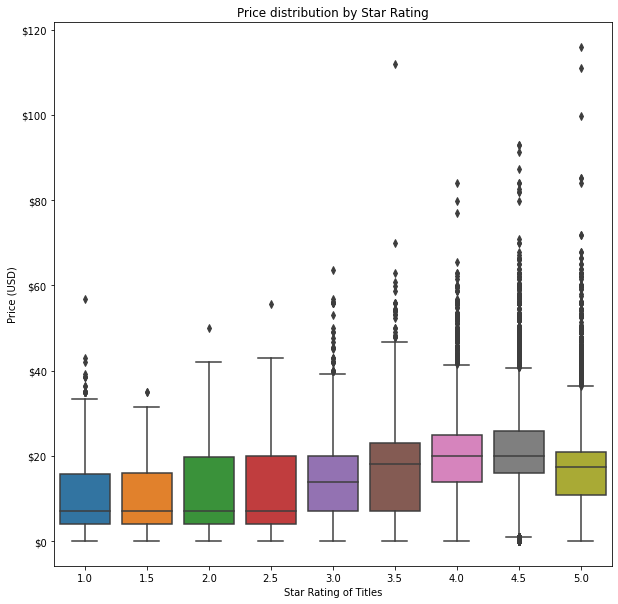

In [132]:
star_order   = [str(x/2) for x in list(range(2,11,1))]
star_order

plot = sns.boxplot(x=titles.star_rating,
           y=titles.price, order = star_order)

plt.xlabel("Star Rating of Titles")
plt.ylabel("Price (USD)")
plt.title("Price distribution by Star Rating")

yticks = ["$"+str(x) for x in range(-20,121,20)]
plot.set_yticklabels(yticks)

plt.savefig("./graphics/stars_vs_price.png", bbox_inches = 'tight')

# Number of Categories <a id='categories'></a>
[Back to top](#top)

Since the Audible category system functions more like tags rather than distict categories. Titles can be found in mutliple semi-related categories.

More than half the books are only listed in 1 category while a few are listed in as many as 30. These 'widely distributed' titles tend to be about historical events or social phenomena (i.e. *Alone Together*). 

Category Number Mean: 2.20
Category Number Median: 1.00


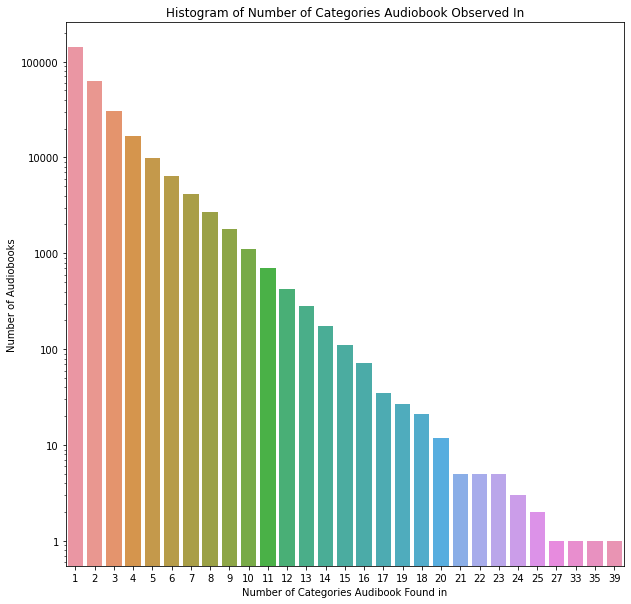

In [135]:
plot = sns.countplot(x='category_number', 
                     data = titles, 
                     order = titles['category_number'].value_counts().index)

plot.set_xlabel("Number of Categories Audibook Found in")
plot.set_ylabel("Number of Audiobooks")
plot.set_title("Histogram of Number of Categories Audiobook Observed In")

plt.savefig("./graphics/cat_numb_hist.png", bbox_inches = 'tight')

plot.set_yscale('log')
yticks = [1,10,100,1000,10000,100000]
plot.set_yticks(yticks)
plot.set_yticklabels(yticks)
plt.savefig("./graphics/cat_numb_log_hist.png", bbox_inches = 'tight')

print("Category Number Mean: {:.2f}".format(titles.category_number.mean()))
print("Category Number Median: {:.2f}".format(titles.category_number.median()))

Titles in the most categories seem to be about major social events or war 

In [255]:
print("Top 4 Titles by number of cateogries")
titles.sort_values('category_number', ascending = False).head(4)[['author','narrator','language','title','subtitle','price','title_category','category_number']]

Top 4 Titles by number of cateogries


,author,narrator,language,title,subtitle,price,title_category,category_number
34165,[Timothy Snyder],[Ralph Cosham],English,Bloodlands,Europe Between Hitler and Stalin,29.95,"[United States, Austria & Hungary, Russia, Gre...",39
15644,[Sherry Turkle],[Laural Merlington],English,Alone Together,Why We Expect More from Technology and Less fr...,31.49,"[Philosophy, Workplace Culture, Workplace & Or...",35
99357,[Brendan Simms],[Leighton Pugh],English,Hitler,A Global Biography,30.79,"[Japan, Austria & Hungary, Asia, Russia, Italy...",33
43107,[Serhii Plokhy],[Ralph Lister],English,Chernobyl,The History of a Nuclear Catastrophe,29.95,"[History, History & Culture, Computers & Techn...",27


In [153]:
print("A deeper look at the categories of Alone Togeather \n")
[print(x) for x in titles[(titles.title == "Alone Together") & (titles.release_date == "05-10-11")]['title_category']]

A deeper look at the categories of Alone Togeather 

['Philosophy', 'Workplace Culture', 'Workplace & Organizational Behavior', 'Technology & Society', 'Content Creation & Social Media', 'History & Culture', 'Computers & Technology', 'Aging & Longevity', 'Adolescent Psychology', 'Adulthood & Aging', 'Child Psychology', 'Compulsive Disorders', 'Social Psychology & Interactions', 'Developmental Psychology', 'Anxiety Disorders', 'Mood Disorders', 'Mental Health', 'Education & Learning', 'Popular Culture', 'Media Studies', 'School-Age Children', 'Teenagers', 'Dysfunctional Families', 'Fatherhood', 'Motherhood', 'Parenting & Families', 'Friendship', 'Marriage & Long-Term Partnerships', 'Grief & Loss', 'Communication & Social Skills', 'Philosophy', 'Society', 'History & Philosophy', 'Science', 'Science & Engineering']


[None]

The list of categories can be 'exploded' (making each entry in the list a new row with duplicated values in the other columns) and each category can be examined individually. 

Below we take a look at the highest and lowest categories by average **star ratings**, **number of ratings**, **length**, **price**, **number of languages**, and **number of titles**. 

In [154]:
titles_categories = titles.explode('title_category')
titles_categories['star_rating'] = titles_categories.star_rating.replace("",np.nan).astype(float)

cat_stats = titles_categories.groupby('title_category').agg({'star_rating':'mean','count_rating':['mean','sum'],'length':'mean', 'price':'mean','language':'nunique','title':'count'})

#### Average Star Rating, Highest and Lowest

In [155]:
cat_stats.shape

(800, 7)

In [165]:
cat_stats.sort_values(('star_rating','mean'), ascending = False)[0:5]#.index

star_rating count_rating                length  \
                             mean         mean       sum        mean   
title_category                                                         
Math                     4.875000    12.635135     935.0   92.702703   
Christian Living         4.778205   531.103333  637324.0  420.316667   
Ministry & Evangelism    4.777211   307.538333  369046.0  474.975000   
Spiritual Growth         4.775237   390.070000  468084.0  403.979167   
Christianity             4.758929   641.391667  769670.0  582.339167   

                           price language title  
                            mean  nunique count  
title_category                                   
Math                    8.820946        2    74  
Christian Living       21.334700        2  1200  
Ministry & Evangelism  20.994583        2  1200  
Spiritual Growth       20.907092        2  1200  
Christianity           22.620933        2  1200

In [182]:
cat_stats.sort_values(('star_rating','mean'), ascending = True)[0:5]#.index

star_rating count_rating             length     price  \
                        mean         mean    sum        mean      mean   
title_category                                                           
Hebrew              3.295455     1.132231  137.0  150.619835  9.685455   
Slavic Languages    3.340000     0.330049  134.0  169.908867  9.722094   
Turkish             3.357143     0.311239  108.0  158.028818  9.722219   
Hungarian           3.375000     0.476744   41.0  166.651163  9.604651   
Serbo-Croatian      3.400000     0.300000   24.0  148.600000  9.635250   

                 language title  
                  nunique count  
title_category                   
Hebrew                 26   121  
Slavic Languages       26   406  
Turkish                26   347  
Hungarian              24    86  
Serbo-Croatian         25    80

#### Average Number of Ratings, Highest and Lowest

In [174]:
cat_stats.sort_values(('count_rating','mean'), ascending = False)[0:5]#.index

star_rating  count_rating  \
                                                       mean          mean   
title_category                                                              
All Categories                                     4.652705  11056.617181   
Suspense                                           4.435512   5287.598997   
Genre Fiction                                      4.358689   4197.723461   
Literary Fiction                                   4.349642   3751.103101   
Relationships, Parenting & Personal Development    4.653361   3084.012500   

                                                                 length  \
                                                        sum        mean   
title_category                                                            
All Categories                                   13256884.0  742.741451   
Suspense                                          6329256.0  728.437761   
Genre Fiction                                     7908511.0  696.728238   
Literary Fiction                                  4838923.0  784.781395   
Relationships, Parenting & Personal Development   3700815.0  471.141667   

                                                     price language title  
                                                      mean  nunique count  
title_category                                                             
All Categories                                   28.063028        2  1199  
Suspense                                         27.807444        1  1197  
Genre Fiction                                    25.512956        7  1884  
Literary Fiction                                 27.912426        7  1290  
Relationships, Parenting & Personal Development  22.551225        3  1200

In [181]:
cat_stats.sort_values(('count_rating','mean'), ascending = True)[0:5]#.index

star_rating count_rating             length     price  \
                        mean         mean    sum        mean      mean   
title_category                                                           
Flowers & Plants    4.285714     0.156863    8.0   23.470588  5.217843   
Serbo-Croatian      3.400000     0.300000   24.0  148.600000  9.635250   
Turkish             3.357143     0.311239  108.0  158.028818  9.722219   
Slavic Languages    3.340000     0.330049  134.0  169.908867  9.722094   
Hungarian           3.375000     0.476744   41.0  166.651163  9.604651   

                 language title  
                  nunique count  
title_category                   
Flowers & Plants        5    51  
Serbo-Croatian         25    80  
Turkish                26   347  
Slavic Languages       26   406  
Hungarian              24    86

#### Average Length, Longest and Shortest

In [164]:
cat_stats.sort_values(('length','mean'), ascending = False)[0:5]#.index

star_rating count_rating                 length  \
                           mean         mean        sum        mean   
title_category                                                        
Americas               4.541281  1269.841667  1523810.0  881.560833   
Politics & Activism    4.489206   929.019167  1114823.0  865.569167   
Epic                   4.566885  2269.242359  5271450.0  851.352561   
Individual Wars        4.510239   587.680833   705217.0  850.184167   
Sagas                  4.424851   975.937500  1171125.0  822.236667   

                         price language title  
                          mean  nunique count  
title_category                                 
Americas             29.327292        2  1200  
Politics & Activism  28.805933        6  1200  
Epic                 26.764537       10  2323  
Individual Wars      27.751208        3  1200  
Sagas                27.055925        5  1200

In [180]:
cat_stats.sort_values(('length','mean'), ascending = True)[0:5]#.index

star_rating count_rating              length  \
                               mean         mean      sum       mean   
title_category                                                         
Nursery Rhymes             4.546512     2.202532    348.0  16.335443   
Beginner Readers           4.361809     9.481100  11036.0  17.793814   
Flowers & Plants           4.285714     0.156863      8.0  23.470588   
Oceans & Water             4.500000     0.812500     39.0  26.687500   
Ducks & Other Waterfowl    4.421053    13.181159   1819.0  32.847826   

                            price language title  
                             mean  nunique count  
title_category                                    
Nursery Rhymes           4.936013        6   158  
Beginner Readers         5.023093        6  1164  
Flowers & Plants         5.217843        5    51  
Oceans & Water           6.173542        3    48  
Ducks & Other Waterfowl  5.698986        6   138

#### Average Price, Expensive and Cheap

In [170]:
cat_stats.sort_values(('price','mean'), ascending = False)[0:5]#.index

star_rating  count_rating                  length  \
                             mean          mean         sum        mean   
title_category                                                            
Americas                 4.541281   1269.841667   1523810.0  881.560833   
Politics & Activism      4.489206    929.019167   1114823.0  865.569167   
Politics & Government    4.587585   1504.155833   1804987.0  819.077500   
All Categories           4.652705  11056.617181  13256884.0  742.741451   
Literary Fiction         4.349642   3751.103101   4838923.0  784.781395   

                           price language title  
                            mean  nunique count  
title_category                                   
Americas               29.327292        2  1200  
Politics & Activism    28.805933        6  1200  
Politics & Government  28.306592        2  1200  
All Categories         28.063028        2  1199  
Literary Fiction       27.912426        7  1290

In [179]:
cat_stats.sort_values(('price','mean'), ascending = True)[0:5]#.index

star_rating count_rating              length     price  \
                        mean         mean      sum       mean      mean   
title_category                                                            
Nursery Rhymes      4.546512     2.202532    348.0  16.335443  4.936013   
Beginner Readers    4.361809     9.481100  11036.0  17.793814  5.023093   
Flowers & Plants    4.285714     0.156863      8.0  23.470588  5.217843   
Early Readers       4.475309     4.529167   5435.0  51.457500  5.451525   
Easter              4.542857     5.658824    481.0  39.729412  5.627765   

                 language title  
                  nunique count  
title_category                   
Nursery Rhymes          6   158  
Beginner Readers        6  1164  
Flowers & Plants        5    51  
Early Readers          13  1200  
Easter                  4    85

#### Number of Languages, Most and Least

In [173]:
cat_stats.sort_values(('language','nunique'), ascending = False)[0:5]#.index

star_rating count_rating               length  \
                                 mean         mean      sum        mean   
title_category                                                            
Southeast Asian Languages    3.406250     0.479830    226.0  175.972399   
Chinese Languages            4.321429     4.821306   1403.0  199.288660   
French                       4.325167    17.131944  14802.0  172.083333   
Russian                      4.296610    18.972337  13717.0  296.561549   
German                       4.329167     8.485030   7085.0  133.699401   

                               price language title  
                                mean  nunique count  
title_category                                       
Southeast Asian Languages   9.964628       28   471  
Chinese Languages          12.149175       27   291  
French                     10.871146       26   864  
Russian                    10.574952       26   723  
German                      9.938874       26   835

In [178]:
cat_stats.sort_values(('language','nunique'), ascending = True)[0:5]#.index

star_rating count_rating           \
                                         mean         mean      sum   
title_category                                                        
Thanksgiving                         4.345238     8.000000    600.0   
Amish & Mennonite                    4.472754    58.417293  46617.0   
Step Parenting & Blended Families    4.214286    35.866667   1614.0   
Asian American Studies               4.204918   114.602740   8366.0   
Gender-Specific Topics               4.388889    44.173913   3048.0   

                                       length      price language title  
                                         mean       mean  nunique count  
title_category                                                           
Thanksgiving                        36.680000   5.664533        1    75  
Amish & Mennonite                  391.224311  18.860238        1   798  
Step Parenting & Blended Families  360.088889  16.885333        1    45  
Asian American Studies             539.643836  21.923562        1    73  
Gender-Specific Topics             275.768116  17.889565        1    69

#### Total Titles, Highest and Lowest

In [161]:
cat_stats.sort_values(('title','count'), ascending = False)[0:5]

star_rating count_rating                  length  \
                                   mean         mean         sum        mean   
title_category                                                                 
Action & Adventure             4.495899  1249.457386  13076821.0  582.276514   
Anthologies & Short Stories    4.200809   204.332665   1834703.0  446.955340   
Historical                     4.419646   560.886964   4694063.0  671.222727   
Science Fiction & Fantasy      4.464313  2306.975202  16001180.0  642.699394   
Literature & Fiction           4.507690  2471.524167  14829145.0  584.856833   

                                 price language  title  
                                  mean  nunique  count  
title_category                                          
Action & Adventure           23.486072       13  10466  
Anthologies & Short Stories  16.362612       16   8979  
Historical                   24.116493       17   8369  
Science Fiction & Fantasy    25.135683        8   6936  
Literature & Fiction         23.444745        5   6000

In [160]:
cat_stats.sort_values(('title','count'), ascending = True)[0:5]

star_rating count_rating              length  \
                                 mean         mean     sum        mean   
title_category                                                           
Latin                        4.200000    20.666667   124.0  388.166667   
Sexuality & Sexual Health    4.615385    28.526316   542.0  368.000000   
Adventurers & Explorers      4.450000     5.476190   115.0   81.190476   
Religious & Liturgical       4.562500     3.750000    90.0  238.625000   
Life Skills                  4.347826    40.333333  1210.0  271.533333   

                               price language title  
                                mean  nunique count  
title_category                                       
Latin                      16.520000        2     6  
Sexuality & Sexual Health  19.324211        3    19  
Adventurers & Explorers     8.087143        2    21  
Religious & Liturgical     12.675417        4    24  
Life Skills                14.395667        1    30

#### EDA

Below I examine some single and double variable distributions. None of these are overly interesting given that they represent the average values of the categories. Two points of note however are the spike in plot 6 of the first chunk. The reason for the large bar at ~1200 is that is the category display limit (60 pages at 20 titles per page). Categories with more titles than 1200 are combinations of identically named categories with different parent categories (Fiction -> Mystery vs Childrens Lit -> Mystery). Not being able to distingish between these categories is an error stemming from the scraping process where the category was determined by the value on the search results page rather than using the url leading to that results page.

<AxesSubplot:xlabel="('title', 'count')", ylabel='Count'>

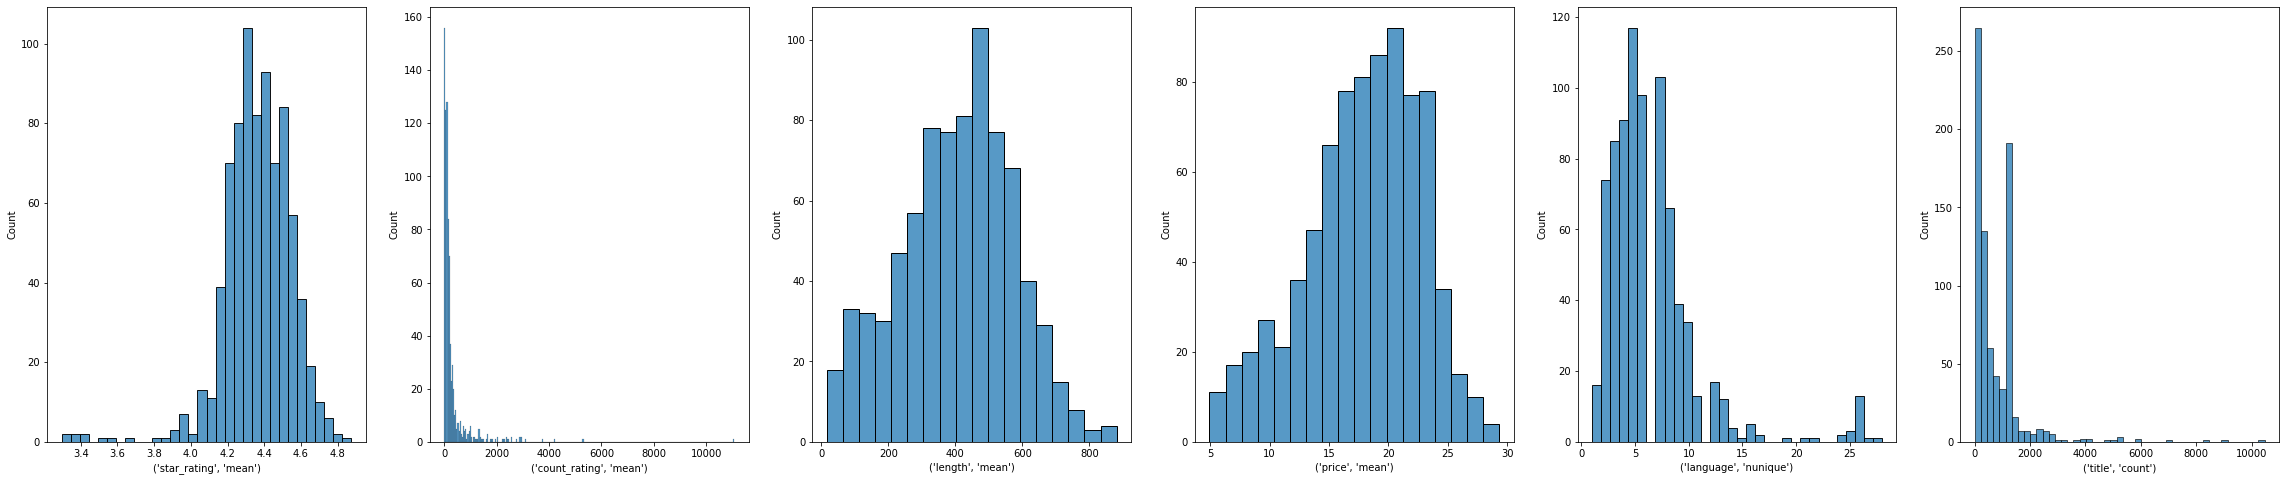

In [183]:
fig, axs = plt.subplots(ncols=6)
fig.set_figwidth(40)
sns.histplot(x= ('star_rating','mean'),
                data = cat_stats,
                ax= axs[0])
sns.histplot(x= ('count_rating','mean'),
                data = cat_stats,
                ax= axs[1],
              )
sns.histplot(x= ('length','mean'),
               data = cat_stats,
                ax= axs[2])
sns.histplot(x= ('price','mean'),
               data = cat_stats,
                ax= axs[3])
sns.histplot(x= ('language','nunique'),
               data = cat_stats,
                ax= axs[4])
sns.histplot(x= ('title','count'),
                data = cat_stats,
                ax= axs[5])

<AxesSubplot:xlabel="('length', 'mean')", ylabel="('count_rating', 'mean')">

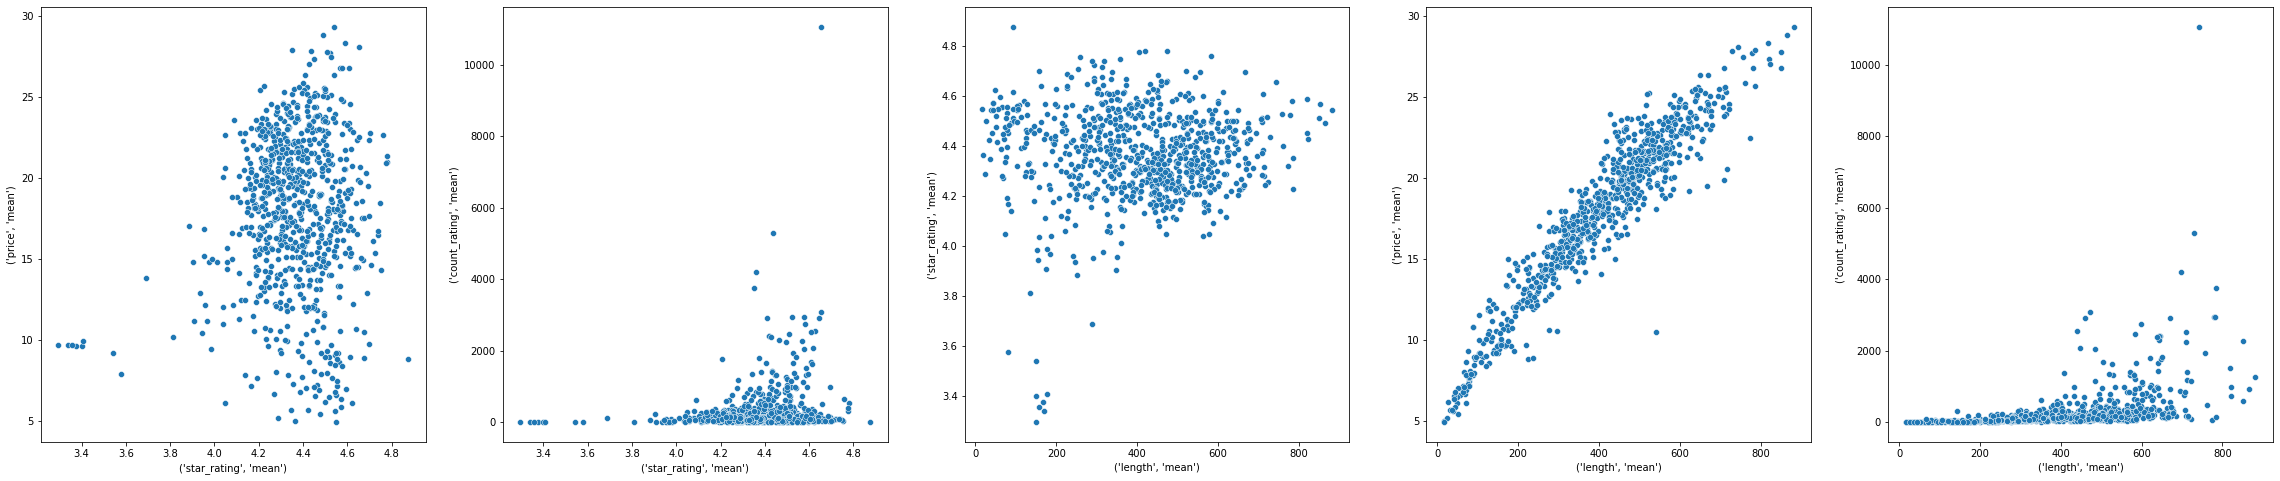

In [175]:
fig, axs = plt.subplots(ncols=5)
fig.set_figwidth(40)
sns.scatterplot(x= ('star_rating','mean'),
                y= ('price','mean'),
                data = cat_stats,
                ax= axs[0])
sns.scatterplot(x= ('star_rating','mean'),
                y= ('count_rating','mean'),
                data = cat_stats,
                ax= axs[1],
              )
sns.scatterplot(x= ('length','mean'),
                y= ('star_rating','mean'),
               data = cat_stats,
                ax= axs[2])
sns.scatterplot(x= ('length','mean'),
                y= ('price','mean'),
               data = cat_stats,
                ax= axs[3])
sns.scatterplot(x= ('length','mean'),
                y= ('count_rating','mean'),
               data = cat_stats,
                ax= axs[4])

# Translation as Revenue Driver <a id='translation'></a>
[Back to top](#top)

English language accounts 1.7 million hours of content, over 90% of the Audible library. This is expected from a company which mainly operates in the US, however only 15% of the global population speaks english, and some of the countries with the highest income growth are not native english speaking countries. 

Audible has begun to address this is multiple markets by using language or country specific landing pages. However this is only a language specific selection of the main library, following any of the 'See More' links will bring you to the standard Audible results page and every title displayed was scraped by this spider. 

Examples:
- [Audible in Chinese](https://www.audible.com/ep/chinese)
- [Audible Latino](https://www.audible.com/ep/audiblelatino)
- [Audible Truly Indian](https://www.audible.in/ep/truly_indian)

In the India market, Audible created [Audible Suno](https://www.audible.in/ep/suno) which expanded its A-List Collection with Bollywood Stars and consists of Audible Originals which are [offered for free](https://yourstory.com/2020/09/audible-suno-amazon-audio-streaming-bet-india/amp) (and were unfortunetly not scrapped).

However, even with all these initiatives, English, German, Spanish, and French (languages offered by the Audible owned ACX) account for 94% of all titles but only ~15% of speakers around the world.

Using some simple math, we can estimate that at minimum there are 1.5 million hours of non-translated English content avalible in the form of 244,000 titles.

In [178]:
total_hours = titles.length.sum()/60
total_hours_by_lang = (titles.groupby('language')['length'].sum()/60).sort_values(ascending=False)
percent_hours = (total_hours_by_lang / total_hours_by_lang.sum()*100).sort_values(ascending=False)
percent_titles = (titles.groupby('language')['length'].size() / titles.shape[0] * 100).sort_values(ascending=False)

print("Total Audible Hours {}".format(total_hours))
print("Total Audible Titles {}".format(titles.shape[0]))
print('\nNumber of Hours by language: Top 3')
print(total_hours_by_lang[0:3])
print('\nPercent of Total Hours by language: Top 3')
print(percent_hours[0:3])
print('\nPercent of Total Titles by language: Top 3')
print(percent_titles[0:3])

print('\n Percent Titles Covered by ACX Producers (voice actors)')
print("{:.2f}".format(titles[titles.language.isin(["English", "German", "Spanish"])].shape[0] / titles.shape[0] *100))

Total Audible Hours 1854700.75
Total Audible Titles 279186

Number of Hours by language: Top 3
language
English    1.694328e+06
German     5.507983e+04
Spanish    3.738625e+04
Name: length, dtype: float64

Percent of Total Hours by language: Top 3
language
English    91.353154
German      2.969742
Spanish     2.015756
Name: length, dtype: float64

Percent of Total Titles by language: Top 3
language
English    87.452809
German      4.009872
Spanish     2.536660
Name: length, dtype: float64

 Percent Titles Covered by ACX Producers (voice actors)
94.00


## Do translated titles do better than expected?

Does not seem like it, star ratings tend to be a bit more 5-star than normal but the books tend to be shorter, cheaper, and get fewer reviews.

<AxesSubplot:xlabel='english', ylabel='price'>

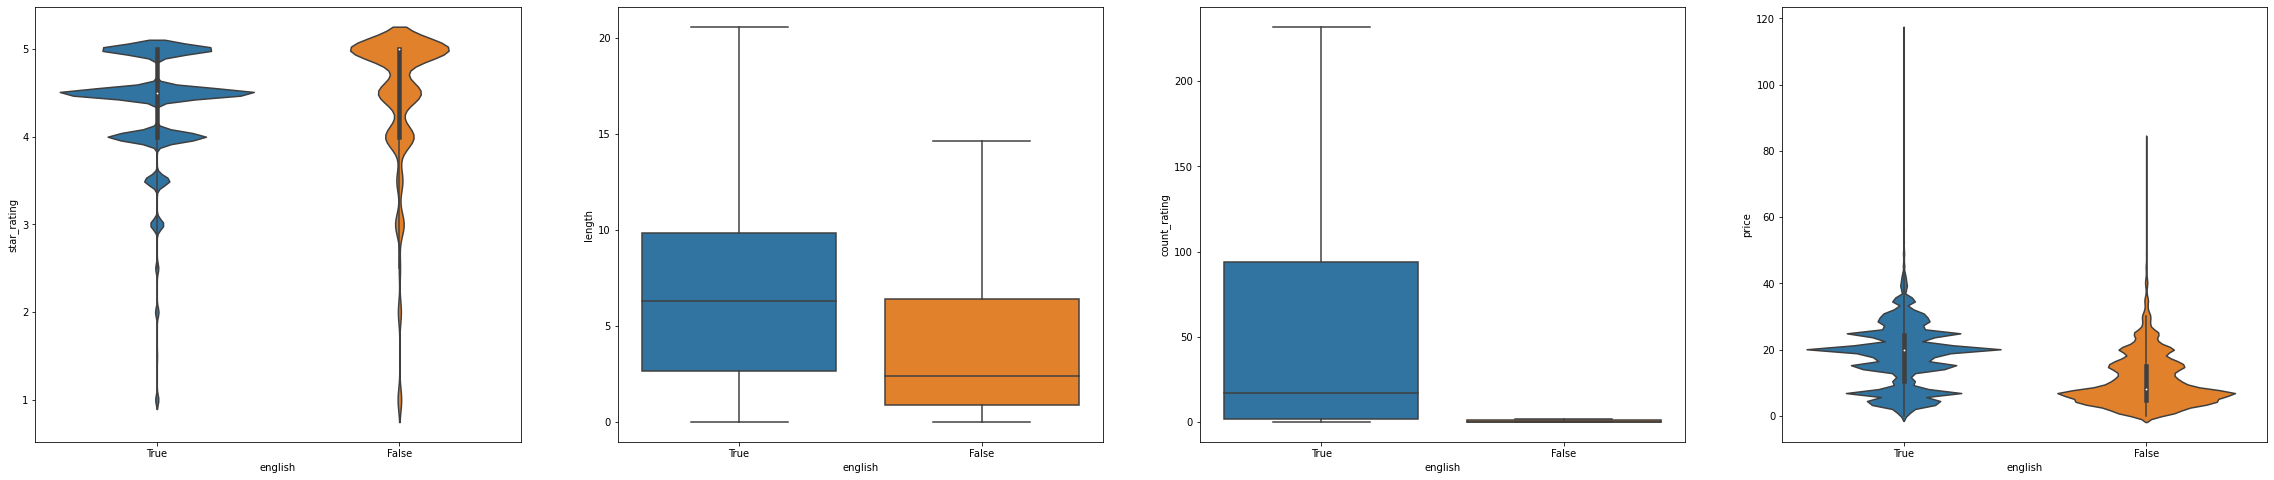

In [168]:
titles['english'] = [str(x == "English") for x in titles.language]

fig, axs = plt.subplots(ncols=4)
fig.set_figwidth(40)
sns.violinplot(x= 'english',
               y= 'star_rating',
                data = titles,
                ax= axs[0])
sns.boxplot(x= 'english',
               y= titles.length/60,
                showfliers = False,
            data = titles,
                ax= axs[1])
sns.boxplot(x= 'english' ,
               y= 'count_rating',
                data = titles,
                showfliers = False,
                ax= axs[2])
sns.violinplot(x='english',
              y = 'price',
              data = titles,
              ax = axs[3])



## Estimating language length variance

Using the books written by [J.K. Rowling](https://www.audible.com/search?ref=a_search_c4_pageNum_1&pf_rd_p=1d79b443-2f1d-43a3-b1dc-31a2cd242566&pf_rd_r=JJFBVCT0JR0BAFH7EC96&searchAuthor=J.K.%20Rowling&page=2), one of the most translated Authors, we can look at the variance between translations of the same book. 

Each book was assinged a value based on its occurance in the series, zeros are for non Harry Potter Series books (I used the translation and word search features of excel to speed up the process). Then the these values ard added as a series_id value.

Then grouping by book, the mean and standard deviation of lengths are plotted against each book in the series. We can see that standard deviation in translation increases with the length of the book. To adjust for this I took the percent standard deviation (std dev / mean length), which has an average of 7.4%.

Next I wrote a function to judge if an author has a translation of a book avalible based on the lengths of books they wrote. So if author A has two books with less than 7.4%*length difference they are considered translations of the same book.

Unfortunetly the implementation of the approach is sub-standard. It take over an hour to run and severl of the top results have translations avalible which this approach missed. 

In [181]:
titles_authors = titles.explode('author')
rowling_subset = titles_authors[titles_authors.author == 'J.K. Rowling']

In [182]:
#get all books, then manually code book number
[print(x) for x in rowling_subset.title]

#Done Manually in excel, used built in translate feature, then looked up by keywords {"stone":1,"secrets":2,"azkaban":3,"fire":4,"phenoix":5,"blood":6,"hallows":7}
# only three values needed correction due to mis-translation

book_mask = [0,0,0,0,0,0,0,2,2,7,7,4,4,6,6,5,5,1,3,3,1,1,5,2,4,6,3,7,3,5,7,4,6,2,1,1,
             4,7,3,5,6,2,1,1,7,7,3,4,5,5,6,6,2,4,2,3,1,2,4,6,3,5,2,1,7,0,0,0,0,0,0,0,0]
rowling_subset['series_id'] = book_mask

Animales fantásticos y dónde encontrarlos [Fantastic Beasts and Where to Find Them]
Der Ickabog (German Edition)
Die Märchen von Beedle dem Barden [The Tales of Beedle the Bard]
El Ickabog (Narración en Castellano) [The Ickabog]
El Ickabog (Spanish Edition)
Fantastic Beasts and Where to Find Them
Harry Potter à l'École des Sorciers
Harry Potter and the Chamber of Secrets, Book 2
Harry Potter and the Chamber of Secrets, Book 2
Harry Potter and the Deathly Hallows, Book 7
Harry Potter and the Deathly Hallows, Book 7
Harry Potter and the Goblet of Fire, Book 4
Harry Potter and the Goblet of Fire, Book 4
Harry Potter and the Half-Blood Prince, Book 6
Harry Potter and the Half-Blood Prince, Book 6
Harry Potter and the Order of the Phoenix, Book 5
Harry Potter and the Order of the Phoenix, Book 5
Harry Potter and the Philosopher's Stone, Book 1
Harry Potter and the Prisoner of Azkaban, Book 3
Harry Potter and the Prisoner of Azkaban, Book 3
Harry Potter and the Sorcerer's Stone, Book 1
Harr

<ipython-input-182-622decdcf376>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  rowling_subset['series_id'] = book_mask


                length             title std percent
                  mean         std count            
series_id                                           
1           572.000000   52.592775     9    0.091945
2           631.444444   58.440378     9    0.092550
3           776.875000   59.860403     8    0.077053
4          1370.500000   84.699469     8    0.061802
5          1842.625000  129.457039     8    0.070257
6          1240.750000   73.186162     8    0.058985
7          1473.375000   97.754704     8    0.066347
The average STDEV between languages of the same book is: 79.43 minutes
The average Percent STDEV between languages of the same book is: 7.41%


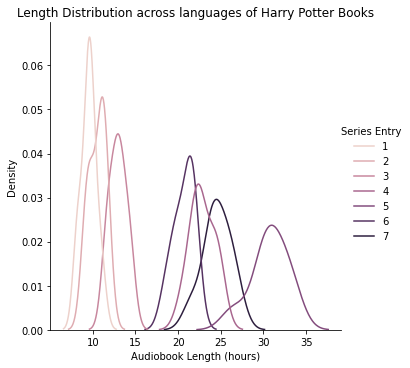

In [184]:
data = rowling_subset[rowling_subset.series_id >0]

plot = sns.displot(x=data.length/60,hue=data.series_id,kind='kde')


plt.xlabel("Audiobook Length (hours)")
plt.title("Length Distribution across languages of Harry Potter Books")
plot._legend.set_title("Series Entry")

plt.savefig("./graphics/HP_by_lang.png", bbox_inches = 'tight')


HP_len_stats = data.groupby('series_id').agg({"length":['mean','std'],'title':'count'})
HP_len_stats['std percent'] = HP_len_stats[('length','std')] / HP_len_stats[('length','mean')]

print(HP_len_stats)
print("The average STDEV between languages of the same book is: {:.2f} minutes".format(HP_len_stats[("length",'std')].mean()))
print("The average Percent STDEV between languages of the same book is: {:.2f}%".format(HP_len_stats['std percent'].mean()*100))

In [296]:
# writing an aggregation function to test this.
titles_authors = titles.explode('author')


def alt_lang(row):
    length = row['length']
    length_margin = length * 0.0741
    language = row['language']
    author = row['author']

    if language != "English":
        return None
    
    alt_candidates = titles_authors[(titles_authors.author == author) & (titles_authors.language != language) & (abs(titles_authors.length - length) <= length_margin)]
    
    
    return (alt_candidates.shape[0] > 0)


#rowling_subset[0:10].apply(alt_lang, axis = 1)
#print(titles_authors[titles_authors.author == 'J.K. Rowling'][['title','language']])
#titles_authors[titles_authors.author == 'J.K. Rowling'].apply(alt_lang, axis=1)

#print(titles_authors[titles_authors.author == 'Ernest Cline'][['title','language']])
#titles_authors[titles_authors.author == 'Ernest Cline'].apply(alt_lang, axis=1)

#print(titles_authors[titles_authors.author == 'Andy Weir'][['title','language']])
#titles_authors[titles_authors.author == 'Andy Weir'].apply(alt_lang, axis=1)

print(titles_authors[titles_authors.author == 'Mark Manson'][['title','language']])
titles_authors[titles_authors.author == 'Mark Manson'].apply(alt_lang, axis=1)


                                                    title language
70065       El amor no es suficiente [Love Is Not Enough]  Spanish
70499   El sutil arte de que te importe un caraj [The ...  Spanish
75447                                Everything Is F*cked  English
123434                                  L'amore non basta  Italian
132640                                 Love Is Not Enough  English
142966                                             Models  English
245568                The Subtle Art of Not Giving a F*ck  English
245569  The Subtle Art of Not Giving a F*ck (Gujarati ...  English
245570  The Subtle Art of Not Giving a F*ck (Malayalam...  English


70065      None
70499      None
75447      True
123434     None
132640     True
142966     True
245568    False
245569     True
245570    False
dtype: object

In [275]:
%%time
titles_authors[0:1].apply(alt_lang,axis=1)

#1 : 52ms
#10: 451 ms
#100: 1741 ms
#1000: 21000 ms

# for the chunk below ("english, 4 stars or above, and more than 3 ratings")
#  estimated 60 minutes of run time for the filtered chunk (95585)

Wall time: 52 ms


0    False
dtype: bool

#### Warning, chunk will take 90 minutes to run.

In [294]:
# $200 per finish hour of content = 3.3 $ /min
titles_authors['production_cost'] = titles.length * 10/3
data = titles_authors[(titles_authors['language'] == "English") & (titles_authors['star_rating'].isin(['4','4.5','5'])) & (titles_authors['count_rating'] > 3)]

data['translation_avalible'] = data.apply(alt_lang, axis=1)

data[data['translation_avalible'] == False].sort_values('count_rating', ascending = False)

<ipython-input-294-64dfccbc06db>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['translation_avalible'] = data.apply(alt_lang, axis=1)


## Top Titles to Drive Conversion

Instead of determining if each book has a translation based on its author, we can look across all books to identify a thresehold where paying for translations makes sense.

Since Audible is a subscription driven company, each incremental title adds little to the chances of purchasing a subscription. In deciding to purchase a subscription, besides the lifestyle factors, most prospective users are likely to ask, is the next book I want on the platform?

Since ratings and stars are heavily skewed on the platform, and since most media retains so cross-cultural valance, we can focus on the highest proforming books to bring to a new language market. So below we examine how a new language market could be onboarded given linear translation costs and the expected number of users given different likelihoods of rating.  

#### Top Titles to Onboard given $100,000 USD

In [221]:
# to add an arbitrary filter, if we have $100,000 USD to onboard a new market we can get the following.
translation_budget = 100000

titles['star_rating']   = titles['star_rating'].astype('string').replace(np.nan,"")

data = titles[(titles['star_rating'].isin(['4.0','4.5','5.0'])) & (titles.language == "English")]
# adding column for the translation cost, linear at $200 / hour or $3.3 / min.
data['production_cost'] = titles.length * 10/3


new_data = data.sort_values('count_rating', ascending = False)[data.sort_values('count_rating', ascending = False)['production_cost'].cumsum() < translation_budget][['title','count_rating','production_cost']]

new_data.columns = ["Title", "Number of Reviews","Cost to Dub"]
new_data[['Number of Reviews', "Cost to Dub"]] = new_data[['Number of Reviews','Cost to Dub']].round(0).astype(int)
new_data['Cost to Dub'] = ["$"+str(x) for x in new_data['Cost to Dub']]

print(new_data.shape)
new_data

<ipython-input-221-27227f133241>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['production_cost'] = titles.length * 10/3


(29, 3)


,Title,Number of Reviews,Cost to Dub
170312,Ready Player One,241735,$3133
271379,Where the Crawdads Sing,190374,$2440
35431,Born a Crime,181458,$1747
28363,Becoming,166488,$3810
245568,The Subtle Art of Not Giving a F*ck,142825,$1057
220089,The Girl on the Train,137625,$2193
94842,"Harry Potter and the Sorcerer's Stone, Book 1",136563,$1660
40264,Can't Hurt Me,134627,$2723
5948,A Game of Thrones,127534,$6753
94831,"Harry Potter and the Deathly Hallows, Book 7",111595,$4323


#### Alternatively, use book translation sales to predict audiobook performance.

# Category Structure (Work in Progress) <a id='cat'></a>
[Back to top](#top)

Audible has a variety of categories allowing the user to filter their search as desired. Interestingly the category system seems to function more like tags, with content belonging to multiple unconnected categories. Additionally, since only 1200 results are displayed in the search pane, categories containing more than 1200 titles are generally broken down into sub-categories. 

There are 1171 listed categories, 121 redirect to another page, so 1050 were scraped. 

So instead of __ we get directed to __:
- Childrens / Action-Adventure -> Literature-Fiction / Action-Adventure
- Fairy-Tales-Folk-Tales-Myths / Adaptations -> Fantasy-Magic / Fairy-Tale-Adaptations
- Biographies / Historical -> History / Historical-Biographies

#### Resources

https://www.python-graph-gallery.com/324-map-a-color-to-network-nodes \

https://networkx.org/documentation/stable/index.html

https://stackoverflow.com/questions/40092390/network-graph-is-not-visually-optimized-in-networkx

http://graphviz.org/doc/info/attrs.html#d:layout

https://graphviz.readthedocs.io/en/stable/manual.html

https://www.graphviz.org/pdf/dotguide.pdf

https://graphviz.org/doc/info/attrs.html

https://pygraphviz.github.io/documentation/stable/pygraphviz.pdf


# Category EDA <a id='cat_eda'></a>

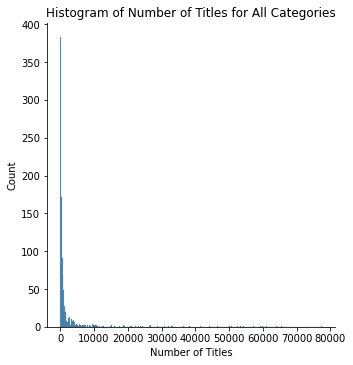

In [40]:
data = cat_data['category_numb_title']
plot = sns.displot(data)

plot.set_axis_labels("Number of Titles")
plt.title("Histogram of Number of Titles for All Categories")

#plt.show()
plt.savefig("./graphics/hist_cats.png", bbox_inches = 'tight')

In [34]:
big_bois = cat_data[cat_data['parent_category']== 'Audible'].filter(items = ['category_name','category_numb_title'])
big_bois.columns = ['Top Level Category Name','Number of Titles']
big_bois.set_index('Top Level Category Name')

,Number of Titles
Top Level Category Name,
Travel & Tourism,8631
Teen,18661
Sports & Outdoors,22415
Science Fiction & Fantasy,61202
Science & Engineering,17495
Romance,63904
Religion & Spirituality,55302
"Relationships, Parenting & Personal Development",58980
Politics & Social Sciences,59844


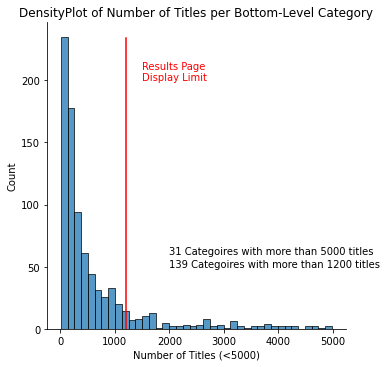

In [17]:
data2 = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] <5001)]['category_numb_title']
plot = sns.displot(data2)

plot.set_axis_labels("Number of Titles (<5000)")
plt.title("DensityPlot of Number of Titles per Bottom-Level Category")
plt.axvline(1200, 0, 0.95, color = 'r')
plt.text(x=1500, y=200, s= "Results Page \nDisplay Limit", color = 'r')

plt.text(x=2000, y=60, s= "31 Categoires with more than 5000 titles", color = 'k')
plt.text(x=2000, y=50, s= "139 Categoires with more than 1200 titles", color = 'k')


#plt.show()
plt.savefig("./graphics/hist_leafs.png", bbox_inches = 'tight')

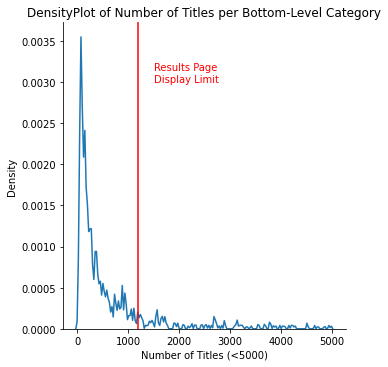

In [29]:
data2 = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] <5001)]['category_numb_title']

plot = sns.displot(data2, kind = 'kde', bw_adjust = 0.05)

plt.axvline(1200, 0, 1, color = 'r')
plt.text(x=1500, y=0.003, s= "Results Page \nDisplay Limit", color = 'r')

plot.set_axis_labels("Number of Titles (<5000)")
plt.title("DensityPlot of Number of Titles per Bottom-Level Category")

#plt.text(x=2000, y=60, s= "31 Categoires with more than 5000 titles", color = 'k')
#plt.text(x=2000, y=50, s= "139 Categoires with more than 1200 titles", color = 'k')

#plt.show()
plt.savefig("./graphics/density_leafs.png", bbox_inches = 'tight')

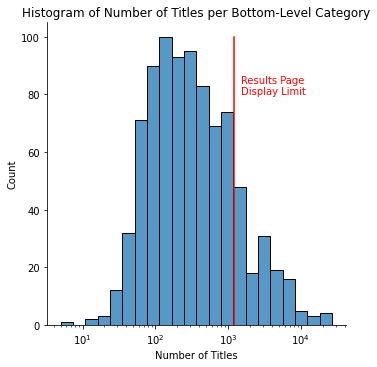

In [204]:
data2 = cat_data[cat_data['leaf_flag']==True]['category_numb_title']
plot = sns.displot(data2,log_scale = True)

plot.set_axis_labels("Number of Titles")
plt.title("Histogram of Number of Titles per Bottom-Level Category")
plt.axvline(1200, 0, 0.95, color = 'r')
plt.text(x=1500, y=80, s= "Results Page \nDisplay Limit", color = 'r')

#plt.text(x=2000, y=60, s= "31 Categoires with more than 5000 titles", color = 'k')
#plt.text(x=2000, y=50, s= "139 Categoires with more than 1200 titles", color = 'k')


plt.show()
#plt.savefig("./graphics/hist_log_leafs.png", bbox_inches = 'tight')

In [24]:
large_leafs = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] >5000)]['category_numb_title']
print("There are {} leaf categories with more than 5000 titles.".format(len(large_leafs)))

display_limit_leafs = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] >1200)]['category_numb_title']
print("There are {} leaf categories with more than 1200 titles, the display limit.".format(len(display_limit_leafs)))

There are 31 leaf categories with more than 5000 titles.
There are 139 leaf categories with more than 1200 titles, the display limit.


In [5]:
cat_data[(cat_data['leaf_flag']==True)].shape

(869, 7)

In [41]:
display_limit_leafs = cat_data[(cat_data['leaf_flag']==True) &  (cat_data['category_numb_title'] >1200)]['category_numb_title']
string = "{} is the upper bound of 'missed' books based on the display limit and number of categories. Likely these larger categories have titles represented in other categories."
print(string.format(sum(display_limit_leafs)))

583153 is the upper bound of 'missed' books based on the display limit and number of categories. Likely these larger categories have titles represented in other categories.


This offers the oppurtunity to expand these leaf-categories into sub-categories which could provide the user more choice. Significantly the top level category of **Erotica** only has two sub-categories **Literature & Fiction** and **Sexual Instruction** which is suprising considering Audible has a feature [specifically targeted](https://qz.com/1116293/audible-is-launching-a-feature-that-lets-you-jump-right-to-the-most-erotic-part-of-an-audiobook/) at this category of audiobooks. My best alternative hypothesis is most **Erotica/Literature & Fiction** titles are also represented in the **Romance** section which is broken down into many sub-categories.  

Personal Success might offer an easy split "Managing your vanity" and "How does my hair look?"

In [54]:
# Top and bottom categories
data2      = cat_data[cat_data['leaf_flag']==True]
top_       = data2.sort_values('category_numb_title',ascending = False).head(5)
bottom_    = data2.sort_values('category_numb_title',ascending = False).tail(5)
top_bottom = pd.concat([top_,bottom_]).filter(items = ['parent_category','category_name','category_numb_title'])
top_bottom.columns = ['Parent Category','Category Name', 'Number of Titles']

#Get URL
#top_bottom = pd.concat([top_,bottom_]).filter(items = ['parent_category','category_name','category_numb_title', 'self_url'])
#top_bottom.columns = ['Parent Category','Category Name', 'Number of Titles', 'Category URL']
#print(top_bottom.to_string())

top_bottom

,Parent Category,Category Name,Number of Titles
174,Personal Development,Personal Success,26798
823,Thriller & Suspense,Suspense,26385
597,Erotica,Literature & Fiction,23118
251,Romance,Contemporary,20868
925,Management & Leadership,Leadership,16045
857,Biographies,Adventurers & Explorers,18
396,"Health, Lifestyle & Relationships",Sexuality & Sexual Health,17
426,Historical Fiction,Action & Adventure,16
401,Science Fiction,Anthologies & Short Stories,13
587,Language Learning,Latin,5


426 : Teen / Lit & Fic / Historical Fiction / A & A

401 : Teen / Scifi & Fantasy / SciFi / Anthology...



# Network Visualization <a id='network'></a>
[Back to top](#top)

In [96]:
# adding a false entry to make assignments easier. 
cat_data = cat_data.append({'category_name':"Audible", 
                            'category_numb_title':361480, 
                            'parent_category':"", 
                            'self_url':"https://www.audible.com/categories",
                            'title_list_url':"",
                            'parent_url':"",
                            'leaf_flag': False},
                           ignore_index = True)

#Creating new column for better node visualization
cat_data['log_numb_title'] = np.log(cat_data['category_numb_title'])
cat_data['scaled_numb_title'] = np.interp(cat_data.category_numb_title,
                                         (cat_data.category_numb_title.min(),
                                         cat_data.category_numb_title.max()),
                                         (1,300))
cat_data['scaled_log_numb_title'] = np.interp(cat_data.log_numb_title,
                                         (cat_data.log_numb_title.min(),
                                         cat_data.log_numb_title.max()),
                                         (1,300))

ValueError: Received invalid argument(s): layout

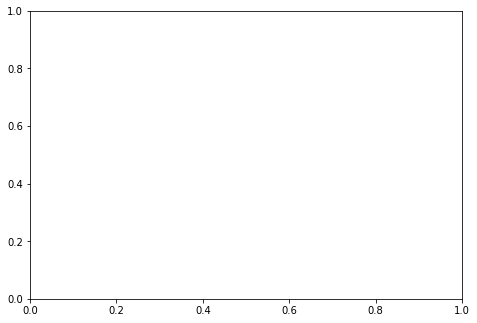

In [3]:
graph = nx.from_pandas_edgelist(cat_data, 'parent_url','self_url', create_using=nx.DiGraph())

node_info = cat_data.set_index('self_url').reindex(graph.nodes())
#node_dic  = node_info.filter(['category_name']).T.to_dict('dict')

nx.draw(graph, 
        with_labels = False,
        labels      = node_info['category_name'],
        arrows      = True,
        #node_color  = node_info['category_numb_title'],
        node_size   = node_info['category_numb_title'], # pretty good
        #node_size   = node_info['log_numb_title'], # very small points, 
        #node_size   = node_info['scaled_numb_title'], # very small points
        #node_size   = node_info['scaled_log_numb_title'], #visable points, too small
        #pos         = nx.fruchterman_reingold_layout(graph) #doesnt seem to work
        layout       = nx.kamada_kawai_layout(graph) #doesnt quite work
       )
#plt.rcParams['figure.figsize'] = (50,50)
plt.title("Audible Categories")
#plt.show()
#plt.savefig("category_network.png")




In [6]:
import graphviz
import pygraphviz
from networkx.drawing.nx_agraph import to_agraph

ImportError: cannot import name '_graphviz' from partially initialized module 'pygraphviz' (most likely due to a circular import) (c:\users\james\dropbox\nydsa\projects\web scraping\finding_the_tree_in_the_forest\local-env\lib\site-packages\pygraphviz\__init__.py)

In [5]:
import graphviz
#import pygraphviz
from networkx.drawing.nx_agraph import to_agraph

edges = list(zip(cat_data.parent_url, cat_data.self_url))


labels = dict(zip(cat_data.self_url,cat_data.category_name))


G = nx.DiGraph() # Create an empty Graph

for k,v in labels.items():
    G.add_node(k,label=v)
G.add_edges_from(edges)

A = to_agraph(G)

A.draw('hier_categories.png', prog='dot') # Hierarchical
A.draw('circular_categories.png', prog='neato') #circular

ImportError: requires pygraphviz http://pygraphviz.github.io/

In [ ]:
import graphviz
import pygraphviz
from networkx.drawing.nx_agraph import to_agraph

cat_data = cat_data.append({'category_name':"Audible", 
                            'category_numb_title':361480, 
                            'parent_category':"", 
                            'self_url':"https://www.audible.com/categories",
                            'title_list_url':"",
                            'parent_url':"",
                            'leaf_flag': False},
                           ignore_index = True)

graph = nx.DiGraph()
graph.add_nodes_from()
graph.add_edges_from()
